# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([ 0.03243105, -0.2142088 , -0.00540461,  0.24899444]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.5318385728384607 -2.7694209761377078


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    return actions, states, rewards

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [30]:
def model_loss(states, actions, rewards, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits[:-1], labels=actions_labels[1:])
    R = tf.reduce_mean(rewards)
    loss = tf.reduce_mean(-log_prob*R)        
    return actions_logits, loss

In [31]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [32]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.rewards = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, rewards=self.rewards) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [33]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [34]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(500, 4) actions:(500,)
2


In [35]:
# Training parameters
train_episodes = 10000         # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [36]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [41]:
# Initialize the simulation
state = env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [42]:
state, reward, action

(array([ 0.13492089,  0.3840461 , -0.19820573, -0.89684619]), 1.0, 0)

In [40]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        state=env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            memory.buffer.append([action, state, reward])

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions, 
                                                                     model.states: states, 
                                                                     model.rewards: rewards})
            loss_batch.append(loss)
            total_reward += reward
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.9f}'.format(np.mean(loss_batch)),
              'Explore P: {:.9f}'.format(explore_p))

        # At the end of each episode/epoch
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 Total reward: 13.0 Average loss: -0.685627103 Explore P: 0.998713836
Episode: 1 Total reward: 24.0 Average loss: -1.074895978 Explore P: 0.996343768
Episode: 2 Total reward: 15.0 Average loss: -2.521907806 Explore P: 0.994865362
Episode: 3 Total reward: 9.0 Average loss: -4.457211018 Explore P: 0.993979382
Episode: 4 Total reward: 11.0 Average loss: -7.032615185 Explore P: 0.992897599
Episode: 5 Total reward: 12.0 Average loss: -11.143104553 Explore P: 0.991718830
Episode: 6 Total reward: 15.0 Average loss: -18.292226791 Explore P: 0.990247355
Episode: 7 Total reward: 14.0 Average loss: -30.845672607 Explore P: 0.988875969
Episode: 8 Total reward: 11.0 Average loss: -46.824264526 Explore P: 0.987799798
Episode: 9 Total reward: 23.0 Average loss: -75.896507263 Explore P: 0.985553442
Episode: 10 Total reward: 32.0 Average loss: -146.960968018 Explore P: 0.982436661
Episode: 11 Total reward: 23.0 Average loss: -262.256591797 Explore P: 0.980202627
Episode: 12 Total reward: 28.0

Episode: 98 Total reward: 15.0 Average loss: -9144931.000000000 Explore P: 0.800768251
Episode: 99 Total reward: 14.0 Average loss: -9454936.000000000 Explore P: 0.799661951
Episode: 100 Total reward: 14.0 Average loss: -9877568.000000000 Explore P: 0.798557197
Episode: 101 Total reward: 20.0 Average loss: -10111135.000000000 Explore P: 0.796981659
Episode: 102 Total reward: 16.0 Average loss: -10275370.000000000 Explore P: 0.795723495
Episode: 103 Total reward: 24.0 Average loss: -10464044.000000000 Explore P: 0.793840020
Episode: 104 Total reward: 18.0 Average loss: -10854924.000000000 Explore P: 0.792430377
Episode: 105 Total reward: 9.0 Average loss: -10973456.000000000 Explore P: 0.791726506
Episode: 106 Total reward: 43.0 Average loss: -11497683.000000000 Explore P: 0.788372299
Episode: 107 Total reward: 33.0 Average loss: -12045552.000000000 Explore P: 0.785807904
Episode: 108 Total reward: 13.0 Average loss: -12455778.000000000 Explore P: 0.784800009
Episode: 109 Total reward: 

Episode: 192 Total reward: 11.0 Average loss: -103233968.000000000 Explore P: 0.677343525
Episode: 193 Total reward: 15.0 Average loss: -105000040.000000000 Explore P: 0.676343260
Episode: 194 Total reward: 15.0 Average loss: -108069040.000000000 Explore P: 0.675344494
Episode: 195 Total reward: 10.0 Average loss: -109640552.000000000 Explore P: 0.674679482
Episode: 196 Total reward: 15.0 Average loss: -111285520.000000000 Explore P: 0.673683211
Episode: 197 Total reward: 10.0 Average loss: -109532520.000000000 Explore P: 0.673019859
Episode: 198 Total reward: 34.0 Average loss: -108717648.000000000 Explore P: 0.670769419
Episode: 199 Total reward: 14.0 Average loss: -110621520.000000000 Explore P: 0.669844990
Episode: 200 Total reward: 15.0 Average loss: -114949808.000000000 Explore P: 0.668855964
Episode: 201 Total reward: 29.0 Average loss: -117708792.000000000 Explore P: 0.666948050
Episode: 202 Total reward: 15.0 Average loss: -121421984.000000000 Explore P: 0.665963366
Episode: 2

Episode: 284 Total reward: 23.0 Average loss: -402880992.000000000 Explore P: 0.587267026
Episode: 285 Total reward: 9.0 Average loss: -412327264.000000000 Explore P: 0.586747720
Episode: 286 Total reward: 12.0 Average loss: -421046016.000000000 Explore P: 0.586056037
Episode: 287 Total reward: 12.0 Average loss: -421071360.000000000 Explore P: 0.585365185
Episode: 288 Total reward: 13.0 Average loss: -422455424.000000000 Explore P: 0.584617696
Episode: 289 Total reward: 17.0 Average loss: -429775264.000000000 Explore P: 0.583641676
Episode: 290 Total reward: 8.0 Average loss: -427143424.000000000 Explore P: 0.583182946
Episode: 291 Total reward: 13.0 Average loss: -423844480.000000000 Explore P: 0.582438292
Episode: 292 Total reward: 18.0 Average loss: -438105472.000000000 Explore P: 0.581408830
Episode: 293 Total reward: 8.0 Average loss: -435165696.000000000 Explore P: 0.580951886
Episode: 294 Total reward: 13.0 Average loss: -432109888.000000000 Explore P: 0.580210131
Episode: 295 

Episode: 378 Total reward: 9.0 Average loss: -794502912.000000000 Explore P: 0.519079882
Episode: 379 Total reward: 9.0 Average loss: -796747968.000000000 Explore P: 0.518621916
Episode: 380 Total reward: 10.0 Average loss: -792582528.000000000 Explore P: 0.518113548
Episode: 381 Total reward: 11.0 Average loss: -780239296.000000000 Explore P: 0.517554931
Episode: 382 Total reward: 14.0 Average loss: -776385472.000000000 Explore P: 0.516844851
Episode: 383 Total reward: 13.0 Average loss: -774427776.000000000 Explore P: 0.516186381
Episode: 384 Total reward: 19.0 Average loss: -785865536.000000000 Explore P: 0.515225540
Episode: 385 Total reward: 21.0 Average loss: -794388032.000000000 Explore P: 0.514165679
Episode: 386 Total reward: 9.0 Average loss: -782437952.000000000 Explore P: 0.513712134
Episode: 387 Total reward: 13.0 Average loss: -784309120.000000000 Explore P: 0.513057734
Episode: 388 Total reward: 24.0 Average loss: -788807232.000000000 Explore P: 0.511851843
Episode: 389 

Episode: 470 Total reward: 13.0 Average loss: -1396498944.000000000 Explore P: 0.460476064
Episode: 471 Total reward: 10.0 Average loss: -1411132800.000000000 Explore P: 0.460025813
Episode: 472 Total reward: 13.0 Average loss: -1399571712.000000000 Explore P: 0.459441159
Episode: 473 Total reward: 13.0 Average loss: -1412995328.000000000 Explore P: 0.458857266
Episode: 474 Total reward: 13.0 Average loss: -1439029760.000000000 Explore P: 0.458274130
Episode: 475 Total reward: 12.0 Average loss: -1447739008.000000000 Explore P: 0.457736524
Episode: 476 Total reward: 11.0 Average loss: -1431724160.000000000 Explore P: 0.457244285
Episode: 477 Total reward: 14.0 Average loss: -1468002560.000000000 Explore P: 0.456618581
Episode: 478 Total reward: 13.0 Average loss: -1458831488.000000000 Explore P: 0.456038354
Episode: 479 Total reward: 11.0 Average loss: -1450716672.000000000 Explore P: 0.455547981
Episode: 480 Total reward: 12.0 Average loss: -1460660224.000000000 Explore P: 0.455013644

Episode: 561 Total reward: 11.0 Average loss: -2072285568.000000000 Explore P: 0.412383230
Episode: 562 Total reward: 11.0 Average loss: -2105689728.000000000 Explore P: 0.411940852
Episode: 563 Total reward: 10.0 Average loss: -2091826816.000000000 Explore P: 0.411539112
Episode: 564 Total reward: 15.0 Average loss: -2099397120.000000000 Explore P: 0.410937255
Episode: 565 Total reward: 12.0 Average loss: -2108555904.000000000 Explore P: 0.410456419
Episode: 566 Total reward: 11.0 Average loss: -2139498496.000000000 Explore P: 0.410016159
Episode: 567 Total reward: 9.0 Average loss: -2144344960.000000000 Explore P: 0.409656306
Episode: 568 Total reward: 11.0 Average loss: -2124034432.000000000 Explore P: 0.409216926
Episode: 569 Total reward: 9.0 Average loss: -2085196032.000000000 Explore P: 0.408857792
Episode: 570 Total reward: 10.0 Average loss: -2078927872.000000000 Explore P: 0.408459134
Episode: 571 Total reward: 13.0 Average loss: -2118970880.000000000 Explore P: 0.407941474
E

Episode: 655 Total reward: 10.0 Average loss: -2985245952.000000000 Explore P: 0.369460733
Episode: 656 Total reward: 11.0 Average loss: -2921309184.000000000 Explore P: 0.369065543
Episode: 657 Total reward: 19.0 Average loss: -2941976576.000000000 Explore P: 0.368383966
Episode: 658 Total reward: 10.0 Average loss: -3031697920.000000000 Explore P: 0.368025761
Episode: 659 Total reward: 10.0 Average loss: -3009487360.000000000 Explore P: 0.367667915
Episode: 660 Total reward: 8.0 Average loss: -3019413248.000000000 Explore P: 0.367381895
Episode: 661 Total reward: 12.0 Average loss: -3007954688.000000000 Explore P: 0.366953294
Episode: 662 Total reward: 13.0 Average loss: -3047912960.000000000 Explore P: 0.366489556
Episode: 663 Total reward: 9.0 Average loss: -3147443968.000000000 Explore P: 0.366168860
Episode: 664 Total reward: 14.0 Average loss: -3181812224.000000000 Explore P: 0.365670572
Episode: 665 Total reward: 14.0 Average loss: -3200998656.000000000 Explore P: 0.365172982
E

Episode: 747 Total reward: 13.0 Average loss: -3811888640.000000000 Explore P: 0.333469537
Episode: 748 Total reward: 10.0 Average loss: -3804966912.000000000 Explore P: 0.333146229
Episode: 749 Total reward: 12.0 Average loss: -3882746624.000000000 Explore P: 0.332758686
Episode: 750 Total reward: 9.0 Average loss: -3767500288.000000000 Explore P: 0.332468334
Episode: 751 Total reward: 10.0 Average loss: -3748231936.000000000 Explore P: 0.332146027
Episode: 752 Total reward: 9.0 Average loss: -3780715520.000000000 Explore P: 0.331856226
Episode: 753 Total reward: 11.0 Average loss: -3790183424.000000000 Explore P: 0.331502379
Episode: 754 Total reward: 11.0 Average loss: -3766864896.000000000 Explore P: 0.331148921
Episode: 755 Total reward: 12.0 Average loss: -3861364992.000000000 Explore P: 0.330763773
Episode: 756 Total reward: 12.0 Average loss: -3813959936.000000000 Explore P: 0.330379088
Episode: 757 Total reward: 17.0 Average loss: -3924495616.000000000 Explore P: 0.329834906
E

Episode: 840 Total reward: 9.0 Average loss: -5719332864.000000000 Explore P: 0.301111089
Episode: 841 Total reward: 10.0 Average loss: -5745304576.000000000 Explore P: 0.300820123
Episode: 842 Total reward: 15.0 Average loss: -5787845120.000000000 Explore P: 0.300384220
Episode: 843 Total reward: 12.0 Average loss: -5828476416.000000000 Explore P: 0.300035968
Episode: 844 Total reward: 8.0 Average loss: -5759028736.000000000 Explore P: 0.299804032
Episode: 845 Total reward: 11.0 Average loss: -5770295296.000000000 Explore P: 0.299485423
Episode: 846 Total reward: 13.0 Average loss: -5775538176.000000000 Explore P: 0.299109336
Episode: 847 Total reward: 14.0 Average loss: -5747510272.000000000 Explore P: 0.298704867
Episode: 848 Total reward: 10.0 Average loss: -5797063680.000000000 Explore P: 0.298416306
Episode: 849 Total reward: 10.0 Average loss: -5856933376.000000000 Explore P: 0.298128034
Episode: 850 Total reward: 10.0 Average loss: -5841011712.000000000 Explore P: 0.297840050
E

Episode: 931 Total reward: 12.0 Average loss: -6860150784.000000000 Explore P: 0.272908206
Episode: 932 Total reward: 10.0 Average loss: -7048418304.000000000 Explore P: 0.272645429
Episode: 933 Total reward: 10.0 Average loss: -7107779072.000000000 Explore P: 0.272382915
Episode: 934 Total reward: 11.0 Average loss: -7172633088.000000000 Explore P: 0.272094452
Episode: 935 Total reward: 9.0 Average loss: -7116714496.000000000 Explore P: 0.271858673
Episode: 936 Total reward: 14.0 Average loss: -7215233536.000000000 Explore P: 0.271492328
Episode: 937 Total reward: 10.0 Average loss: -6958173184.000000000 Explore P: 0.271230966
Episode: 938 Total reward: 16.0 Average loss: -6999787008.000000000 Explore P: 0.270813331
Episode: 939 Total reward: 10.0 Average loss: -7181923840.000000000 Explore P: 0.270552648
Episode: 940 Total reward: 10.0 Average loss: -7239002624.000000000 Explore P: 0.270292225
Episode: 941 Total reward: 12.0 Average loss: -7297809920.000000000 Explore P: 0.269980062


Episode: 1024 Total reward: 10.0 Average loss: -6436028416.000000000 Explore P: 0.248008156
Episode: 1025 Total reward: 9.0 Average loss: -6259696640.000000000 Explore P: 0.247794045
Episode: 1026 Total reward: 9.0 Average loss: -6014321152.000000000 Explore P: 0.247580127
Episode: 1027 Total reward: 10.0 Average loss: -6097085952.000000000 Explore P: 0.247342666
Episode: 1028 Total reward: 8.0 Average loss: -6197821440.000000000 Explore P: 0.247152867
Episode: 1029 Total reward: 9.0 Average loss: -6268902400.000000000 Explore P: 0.246939526
Episode: 1030 Total reward: 9.0 Average loss: -6158397952.000000000 Explore P: 0.246726376
Episode: 1031 Total reward: 10.0 Average loss: -6329669120.000000000 Explore P: 0.246489768
Episode: 1032 Total reward: 11.0 Average loss: -6600487936.000000000 Explore P: 0.246229772
Episode: 1033 Total reward: 21.0 Average loss: -6778780672.000000000 Explore P: 0.245734210
Episode: 1034 Total reward: 13.0 Average loss: -6997057024.000000000 Explore P: 0.245

Episode: 1114 Total reward: 9.0 Average loss: -7047444480.000000000 Explore P: 0.226741401
Episode: 1115 Total reward: 10.0 Average loss: -7146406912.000000000 Explore P: 0.226524768
Episode: 1116 Total reward: 8.0 Average loss: -7216884736.000000000 Explore P: 0.226351618
Episode: 1117 Total reward: 13.0 Average loss: -7394266624.000000000 Explore P: 0.226070543
Episode: 1118 Total reward: 10.0 Average loss: -7544003584.000000000 Explore P: 0.225854581
Episode: 1119 Total reward: 13.0 Average loss: -7475025920.000000000 Explore P: 0.225574152
Episode: 1120 Total reward: 10.0 Average loss: -7303369728.000000000 Explore P: 0.225358686
Episode: 1121 Total reward: 10.0 Average loss: -7168915968.000000000 Explore P: 0.225143435
Episode: 1122 Total reward: 12.0 Average loss: -7227704832.000000000 Explore P: 0.224885417
Episode: 1123 Total reward: 12.0 Average loss: -7233413120.000000000 Explore P: 0.224627709
Episode: 1124 Total reward: 11.0 Average loss: -7282301440.000000000 Explore P: 0.

Episode: 1205 Total reward: 12.0 Average loss: -14356755456.000000000 Explore P: 0.206626294
Episode: 1206 Total reward: 11.0 Average loss: -14429188096.000000000 Explore P: 0.206410124
Episode: 1207 Total reward: 9.0 Average loss: -14189793280.000000000 Explore P: 0.206233435
Episode: 1208 Total reward: 10.0 Average loss: -14140342272.000000000 Explore P: 0.206037299
Episode: 1209 Total reward: 8.0 Average loss: -14256958464.000000000 Explore P: 0.205880532
Episode: 1210 Total reward: 16.0 Average loss: -14331403264.000000000 Explore P: 0.205567374
Episode: 1211 Total reward: 9.0 Average loss: -13886434304.000000000 Explore P: 0.205391442
Episode: 1212 Total reward: 12.0 Average loss: -13649617920.000000000 Explore P: 0.205157113
Episode: 1213 Total reward: 8.0 Average loss: -13653325824.000000000 Explore P: 0.205001050
Episode: 1214 Total reward: 11.0 Average loss: -13656707072.000000000 Explore P: 0.204786667
Episode: 1215 Total reward: 9.0 Average loss: -13989739520.000000000 Explo

Episode: 1294 Total reward: 8.0 Average loss: -9512248320.000000000 Explore P: 0.189128772
Episode: 1295 Total reward: 11.0 Average loss: -9575921664.000000000 Explore P: 0.188931839
Episode: 1296 Total reward: 9.0 Average loss: -9619823616.000000000 Explore P: 0.188770872
Episode: 1297 Total reward: 9.0 Average loss: -9678040064.000000000 Explore P: 0.188610051
Episode: 1298 Total reward: 10.0 Average loss: -9795336192.000000000 Explore P: 0.188431530
Episode: 1299 Total reward: 9.0 Average loss: -9589946368.000000000 Explore P: 0.188271014
Episode: 1300 Total reward: 11.0 Average loss: -9656102912.000000000 Explore P: 0.188075024
Episode: 1301 Total reward: 11.0 Average loss: -10093134848.000000000 Explore P: 0.187879249
Episode: 1302 Total reward: 12.0 Average loss: -10385491968.000000000 Explore P: 0.187665922
Episode: 1303 Total reward: 9.0 Average loss: -10610453504.000000000 Explore P: 0.187506094
Episode: 1304 Total reward: 10.0 Average loss: -10729716736.000000000 Explore P: 0

Episode: 1386 Total reward: 10.0 Average loss: -13504206848.000000000 Explore P: 0.172894857
Episode: 1387 Total reward: 9.0 Average loss: -13433484288.000000000 Explore P: 0.172748318
Episode: 1388 Total reward: 10.0 Average loss: -13459838976.000000000 Explore P: 0.172585651
Episode: 1389 Total reward: 11.0 Average loss: -13338592256.000000000 Explore P: 0.172406905
Episode: 1390 Total reward: 15.0 Average loss: -14141231104.000000000 Explore P: 0.172163477
Episode: 1391 Total reward: 11.0 Average loss: -14388013056.000000000 Explore P: 0.171985195
Episode: 1392 Total reward: 9.0 Average loss: -14188736512.000000000 Explore P: 0.171839474
Episode: 1393 Total reward: 10.0 Average loss: -14833570816.000000000 Explore P: 0.171677715
Episode: 1394 Total reward: 10.0 Average loss: -15616160768.000000000 Explore P: 0.171516119
Episode: 1395 Total reward: 9.0 Average loss: -15950552064.000000000 Explore P: 0.171370819
Episode: 1396 Total reward: 12.0 Average loss: -15684476928.000000000 Exp

Episode: 1475 Total reward: 11.0 Average loss: -11874688000.000000000 Explore P: 0.158666411
Episode: 1476 Total reward: 8.0 Average loss: -11931451392.000000000 Explore P: 0.158547525
Episode: 1477 Total reward: 9.0 Average loss: -11887126528.000000000 Explore P: 0.158413893
Episode: 1478 Total reward: 10.0 Average loss: -11694274560.000000000 Explore P: 0.158265553
Episode: 1479 Total reward: 11.0 Average loss: -12082846720.000000000 Explore P: 0.158102551
Episode: 1480 Total reward: 8.0 Average loss: -12411137024.000000000 Explore P: 0.157984116
Episode: 1481 Total reward: 9.0 Average loss: -12054986752.000000000 Explore P: 0.157850990
Episode: 1482 Total reward: 11.0 Average loss: -13173251072.000000000 Explore P: 0.157688443
Episode: 1483 Total reward: 10.0 Average loss: -13113157632.000000000 Explore P: 0.157540829
Episode: 1484 Total reward: 10.0 Average loss: -12164303872.000000000 Explore P: 0.157393362
Episode: 1485 Total reward: 9.0 Average loss: -12248712192.000000000 Explo

Episode: 1565 Total reward: 11.0 Average loss: -21012692992.000000000 Explore P: 0.145518064
Episode: 1566 Total reward: 11.0 Average loss: -21112481792.000000000 Explore P: 0.145369076
Episode: 1567 Total reward: 11.0 Average loss: -21543800832.000000000 Explore P: 0.145220252
Episode: 1568 Total reward: 9.0 Average loss: -21683400704.000000000 Explore P: 0.145098608
Episode: 1569 Total reward: 9.0 Average loss: -21598803968.000000000 Explore P: 0.144977074
Episode: 1570 Total reward: 9.0 Average loss: -22065551360.000000000 Explore P: 0.144855649
Episode: 1571 Total reward: 9.0 Average loss: -21996984320.000000000 Explore P: 0.144734334
Episode: 1572 Total reward: 10.0 Average loss: -21774700544.000000000 Explore P: 0.144599667
Episode: 1573 Total reward: 9.0 Average loss: -21939476480.000000000 Explore P: 0.144478582
Episode: 1574 Total reward: 8.0 Average loss: -21614985216.000000000 Explore P: 0.144371042
Episode: 1575 Total reward: 9.0 Average loss: -21678626816.000000000 Explore

Episode: 1654 Total reward: 8.0 Average loss: -11585124352.000000000 Explore P: 0.134052510
Episode: 1655 Total reward: 9.0 Average loss: -11233727488.000000000 Explore P: 0.133940913
Episode: 1656 Total reward: 10.0 Average loss: -11498605568.000000000 Explore P: 0.133817034
Episode: 1657 Total reward: 10.0 Average loss: -11710708736.000000000 Explore P: 0.133693279
Episode: 1658 Total reward: 10.0 Average loss: -11995949056.000000000 Explore P: 0.133569647
Episode: 1659 Total reward: 10.0 Average loss: -11693601792.000000000 Explore P: 0.133446139
Episode: 1660 Total reward: 8.0 Average loss: -11671842816.000000000 Explore P: 0.133347422
Episode: 1661 Total reward: 10.0 Average loss: -11957432320.000000000 Explore P: 0.133224136
Episode: 1662 Total reward: 10.0 Average loss: -12455523328.000000000 Explore P: 0.133100974
Episode: 1663 Total reward: 11.0 Average loss: -12039314432.000000000 Explore P: 0.132965637
Episode: 1664 Total reward: 10.0 Average loss: -12302278656.000000000 Exp

Episode: 1745 Total reward: 11.0 Average loss: -18568441856.000000000 Explore P: 0.123250813
Episode: 1746 Total reward: 12.0 Average loss: -19412967424.000000000 Explore P: 0.123114994
Episode: 1747 Total reward: 11.0 Average loss: -19478872064.000000000 Explore P: 0.122990635
Episode: 1748 Total reward: 10.0 Average loss: -20683890688.000000000 Explore P: 0.122877701
Episode: 1749 Total reward: 9.0 Average loss: -20909246464.000000000 Explore P: 0.122776157
Episode: 1750 Total reward: 9.0 Average loss: -20254965760.000000000 Explore P: 0.122674704
Episode: 1751 Total reward: 9.0 Average loss: -19109410816.000000000 Explore P: 0.122573343
Episode: 1752 Total reward: 10.0 Average loss: -19106959360.000000000 Explore P: 0.122460825
Episode: 1753 Total reward: 11.0 Average loss: -19914723328.000000000 Explore P: 0.122337187
Episode: 1754 Total reward: 9.0 Average loss: -20895631360.000000000 Explore P: 0.122236129
Episode: 1755 Total reward: 9.0 Average loss: -20933664768.000000000 Explo

Episode: 1836 Total reward: 9.0 Average loss: -28400025600.000000000 Explore P: 0.113451711
Episode: 1837 Total reward: 10.0 Average loss: -29086525440.000000000 Explore P: 0.113348311
Episode: 1838 Total reward: 9.0 Average loss: -28982099968.000000000 Explore P: 0.113255339
Episode: 1839 Total reward: 12.0 Average loss: -29213472768.000000000 Explore P: 0.113131507
Episode: 1840 Total reward: 10.0 Average loss: -28784404480.000000000 Explore P: 0.113028427
Episode: 1841 Total reward: 11.0 Average loss: -26998163456.000000000 Explore P: 0.112915158
Episode: 1842 Total reward: 11.0 Average loss: -26993281024.000000000 Explore P: 0.112802014
Episode: 1843 Total reward: 8.0 Average loss: -27189227520.000000000 Explore P: 0.112719805
Episode: 1844 Total reward: 12.0 Average loss: -26232924160.000000000 Explore P: 0.112596615
Episode: 1845 Total reward: 9.0 Average loss: -25403899904.000000000 Explore P: 0.112504320
Episode: 1846 Total reward: 9.0 Average loss: -24707346432.000000000 Explo

Episode: 1928 Total reward: 9.0 Average loss: -20332601344.000000000 Explore P: 0.104377712
Episode: 1929 Total reward: 9.0 Average loss: -20356993024.000000000 Explore P: 0.104292810
Episode: 1930 Total reward: 12.0 Average loss: -20241911808.000000000 Explore P: 0.104179727
Episode: 1931 Total reward: 10.0 Average loss: -19842312192.000000000 Explore P: 0.104085594
Episode: 1932 Total reward: 10.0 Average loss: -20004521984.000000000 Explore P: 0.103991556
Episode: 1933 Total reward: 9.0 Average loss: -19610372096.000000000 Explore P: 0.103907001
Episode: 1934 Total reward: 10.0 Average loss: -19626117120.000000000 Explore P: 0.103813141
Episode: 1935 Total reward: 12.0 Average loss: -20945674240.000000000 Explore P: 0.103700633
Episode: 1936 Total reward: 11.0 Average loss: -21793030144.000000000 Explore P: 0.103597619
Episode: 1937 Total reward: 10.0 Average loss: -22109626368.000000000 Explore P: 0.103504068
Episode: 1938 Total reward: 8.0 Average loss: -20657504256.000000000 Expl

Episode: 2020 Total reward: 10.0 Average loss: -21088022528.000000000 Explore P: 0.096289243
Episode: 2021 Total reward: 11.0 Average loss: -20825141248.000000000 Explore P: 0.096194377
Episode: 2022 Total reward: 9.0 Average loss: -20854255616.000000000 Explore P: 0.096116837
Episode: 2023 Total reward: 9.0 Average loss: -20881250304.000000000 Explore P: 0.096039367
Episode: 2024 Total reward: 9.0 Average loss: -20908269568.000000000 Explore P: 0.095961966
Episode: 2025 Total reward: 9.0 Average loss: -20935356416.000000000 Explore P: 0.095884635
Episode: 2026 Total reward: 10.0 Average loss: -20964022272.000000000 Explore P: 0.095798793
Episode: 2027 Total reward: 8.0 Average loss: -20991244288.000000000 Explore P: 0.095730182
Episode: 2028 Total reward: 10.0 Average loss: -21018548224.000000000 Explore P: 0.095644494
Episode: 2029 Total reward: 8.0 Average loss: -20872607744.000000000 Explore P: 0.095576006
Episode: 2030 Total reward: 9.0 Average loss: -20783806464.000000000 Explore

Episode: 2111 Total reward: 9.0 Average loss: -28841484288.000000000 Explore P: 0.088854544
Episode: 2112 Total reward: 9.0 Average loss: -28880689152.000000000 Explore P: 0.088783607
Episode: 2113 Total reward: 13.0 Average loss: -30442276864.000000000 Explore P: 0.088681255
Episode: 2114 Total reward: 10.0 Average loss: -30547804160.000000000 Explore P: 0.088602613
Episode: 2115 Total reward: 10.0 Average loss: -30250516480.000000000 Explore P: 0.088524050
Episode: 2116 Total reward: 9.0 Average loss: -29106233344.000000000 Explore P: 0.088453410
Episode: 2117 Total reward: 9.0 Average loss: -27268214784.000000000 Explore P: 0.088382834
Episode: 2118 Total reward: 10.0 Average loss: -26332491776.000000000 Explore P: 0.088304490
Episode: 2119 Total reward: 12.0 Average loss: -26246168576.000000000 Explore P: 0.088210581
Episode: 2120 Total reward: 10.0 Average loss: -24704845824.000000000 Explore P: 0.088132409
Episode: 2121 Total reward: 10.0 Average loss: -24669917184.000000000 Expl

Episode: 2202 Total reward: 10.0 Average loss: -23057952768.000000000 Explore P: 0.082154160
Episode: 2203 Total reward: 9.0 Average loss: -23634135040.000000000 Explore P: 0.082089251
Episode: 2204 Total reward: 9.0 Average loss: -23045033984.000000000 Explore P: 0.082024399
Episode: 2205 Total reward: 9.0 Average loss: -22893740032.000000000 Explore P: 0.081959607
Episode: 2206 Total reward: 11.0 Average loss: -22931318784.000000000 Explore P: 0.081880495
Episode: 2207 Total reward: 10.0 Average loss: -23099871232.000000000 Explore P: 0.081808650
Episode: 2208 Total reward: 10.0 Average loss: -24020885504.000000000 Explore P: 0.081736877
Episode: 2209 Total reward: 9.0 Average loss: -26192769024.000000000 Explore P: 0.081672343
Episode: 2210 Total reward: 11.0 Average loss: -26760028160.000000000 Explore P: 0.081593547
Episode: 2211 Total reward: 8.0 Average loss: -26848198656.000000000 Explore P: 0.081536295
Episode: 2212 Total reward: 11.0 Average loss: -27300122624.000000000 Explo

Episode: 2291 Total reward: 8.0 Average loss: -35707719680.000000000 Explore P: 0.076135452
Episode: 2292 Total reward: 8.0 Average loss: -35755065344.000000000 Explore P: 0.076082565
Episode: 2293 Total reward: 14.0 Average loss: -38854340608.000000000 Explore P: 0.075990114
Episode: 2294 Total reward: 9.0 Average loss: -37199933440.000000000 Explore P: 0.075930750
Episode: 2295 Total reward: 9.0 Average loss: -36262641664.000000000 Explore P: 0.075871439
Episode: 2296 Total reward: 11.0 Average loss: -36338053120.000000000 Explore P: 0.075799020
Episode: 2297 Total reward: 9.0 Average loss: -37078855680.000000000 Explore P: 0.075739827
Episode: 2298 Total reward: 10.0 Average loss: -36603756544.000000000 Explore P: 0.075674120
Episode: 2299 Total reward: 12.0 Average loss: -38907576320.000000000 Explore P: 0.075595359
Episode: 2300 Total reward: 9.0 Average loss: -39429201920.000000000 Explore P: 0.075536350
Episode: 2301 Total reward: 12.0 Average loss: -41972805632.000000000 Explor

Episode: 2380 Total reward: 11.0 Average loss: -31711160320.000000000 Explore P: 0.070649109
Episode: 2381 Total reward: 10.0 Average loss: -31327092736.000000000 Explore P: 0.070588490
Episode: 2382 Total reward: 9.0 Average loss: -33393170432.000000000 Explore P: 0.070533985
Episode: 2383 Total reward: 10.0 Average loss: -31370385408.000000000 Explore P: 0.070473481
Episode: 2384 Total reward: 9.0 Average loss: -31180109824.000000000 Explore P: 0.070419080
Episode: 2385 Total reward: 10.0 Average loss: -31218708480.000000000 Explore P: 0.070358691
Episode: 2386 Total reward: 9.0 Average loss: -28962154496.000000000 Explore P: 0.070304392
Episode: 2387 Total reward: 9.0 Average loss: -27773974528.000000000 Explore P: 0.070250143
Episode: 2388 Total reward: 9.0 Average loss: -26786715648.000000000 Explore P: 0.070195942
Episode: 2389 Total reward: 11.0 Average loss: -26620231680.000000000 Explore P: 0.070129763
Episode: 2390 Total reward: 9.0 Average loss: -25454213120.000000000 Explor

Episode: 2470 Total reward: 10.0 Average loss: -31647858688.000000000 Explore P: 0.065623454
Episode: 2471 Total reward: 11.0 Average loss: -32807680000.000000000 Explore P: 0.065562302
Episode: 2472 Total reward: 9.0 Average loss: -33326540800.000000000 Explore P: 0.065512318
Episode: 2473 Total reward: 9.0 Average loss: -30901739520.000000000 Explore P: 0.065462379
Episode: 2474 Total reward: 8.0 Average loss: -30939133952.000000000 Explore P: 0.065418027
Episode: 2475 Total reward: 10.0 Average loss: -30978162688.000000000 Explore P: 0.065362637
Episode: 2476 Total reward: 8.0 Average loss: -31017009152.000000000 Explore P: 0.065318365
Episode: 2477 Total reward: 10.0 Average loss: -31806033920.000000000 Explore P: 0.065263074
Episode: 2478 Total reward: 10.0 Average loss: -34555457536.000000000 Explore P: 0.065207838
Episode: 2479 Total reward: 10.0 Average loss: -34641596416.000000000 Explore P: 0.065152658
Episode: 2480 Total reward: 9.0 Average loss: -33513392128.000000000 Explo

Episode: 2559 Total reward: 11.0 Average loss: -30264522752.000000000 Explore P: 0.061060180
Episode: 2560 Total reward: 10.0 Average loss: -30882426880.000000000 Explore P: 0.061009146
Episode: 2561 Total reward: 8.0 Average loss: -29143998464.000000000 Explore P: 0.060968355
Episode: 2562 Total reward: 9.0 Average loss: -26486427648.000000000 Explore P: 0.060922504
Episode: 2563 Total reward: 11.0 Average loss: -26515077120.000000000 Explore P: 0.060866520
Episode: 2564 Total reward: 11.0 Average loss: -27650877440.000000000 Explore P: 0.060810597
Episode: 2565 Total reward: 9.0 Average loss: -28095166464.000000000 Explore P: 0.060764888
Episode: 2566 Total reward: 10.0 Average loss: -28124338176.000000000 Explore P: 0.060714149
Episode: 2567 Total reward: 9.0 Average loss: -28153745408.000000000 Explore P: 0.060668527
Episode: 2568 Total reward: 10.0 Average loss: -28183304192.000000000 Explore P: 0.060617884
Episode: 2569 Total reward: 9.0 Average loss: -27881265152.000000000 Explo

Episode: 2651 Total reward: 9.0 Average loss: -45283688448.000000000 Explore P: 0.056735542
Episode: 2652 Total reward: 10.0 Average loss: -46313324544.000000000 Explore P: 0.056688830
Episode: 2653 Total reward: 9.0 Average loss: -44028182528.000000000 Explore P: 0.056646829
Episode: 2654 Total reward: 9.0 Average loss: -43235147776.000000000 Explore P: 0.056604865
Episode: 2655 Total reward: 10.0 Average loss: -42069807104.000000000 Explore P: 0.056558284
Episode: 2656 Total reward: 10.0 Average loss: -42136571904.000000000 Explore P: 0.056511749
Episode: 2657 Total reward: 10.0 Average loss: -42202685440.000000000 Explore P: 0.056465260
Episode: 2658 Total reward: 10.0 Average loss: -42268581888.000000000 Explore P: 0.056418818
Episode: 2659 Total reward: 10.0 Average loss: -42334441472.000000000 Explore P: 0.056372423
Episode: 2660 Total reward: 10.0 Average loss: -39260921856.000000000 Explore P: 0.056326073
Episode: 2661 Total reward: 10.0 Average loss: -35401826304.000000000 Exp

Episode: 2743 Total reward: 9.0 Average loss: -73411231744.000000000 Explore P: 0.052704527
Episode: 2744 Total reward: 10.0 Average loss: -73561686016.000000000 Explore P: 0.052661844
Episode: 2745 Total reward: 12.0 Average loss: -71269163008.000000000 Explore P: 0.052610681
Episode: 2746 Total reward: 9.0 Average loss: -70811541504.000000000 Explore P: 0.052572348
Episode: 2747 Total reward: 9.0 Average loss: -69629362176.000000000 Explore P: 0.052534050
Episode: 2748 Total reward: 10.0 Average loss: -68710572032.000000000 Explore P: 0.052491538
Episode: 2749 Total reward: 10.0 Average loss: -68844961792.000000000 Explore P: 0.052449067
Episode: 2750 Total reward: 9.0 Average loss: -68460195840.000000000 Explore P: 0.052410880
Episode: 2751 Total reward: 10.0 Average loss: -63017988096.000000000 Explore P: 0.052368491
Episode: 2752 Total reward: 8.0 Average loss: -62138859520.000000000 Explore P: 0.052334610
Episode: 2753 Total reward: 13.0 Average loss: -66593841152.000000000 Explo

Episode: 2835 Total reward: 8.0 Average loss: -44568903680.000000000 Explore P: 0.049056329
Episode: 2836 Total reward: 10.0 Average loss: -44613611520.000000000 Explore P: 0.049017292
Episode: 2837 Total reward: 10.0 Average loss: -44664168448.000000000 Explore P: 0.048978295
Episode: 2838 Total reward: 9.0 Average loss: -44712599552.000000000 Explore P: 0.048943230
Episode: 2839 Total reward: 10.0 Average loss: -43282141184.000000000 Explore P: 0.048904306
Episode: 2840 Total reward: 10.0 Average loss: -46225629184.000000000 Explore P: 0.048865421
Episode: 2841 Total reward: 10.0 Average loss: -46279589888.000000000 Explore P: 0.048826575
Episode: 2842 Total reward: 9.0 Average loss: -46331510784.000000000 Explore P: 0.048791647
Episode: 2843 Total reward: 8.0 Average loss: -44577366016.000000000 Explore P: 0.048760626
Episode: 2844 Total reward: 9.0 Average loss: -44020809728.000000000 Explore P: 0.048725757
Episode: 2845 Total reward: 10.0 Average loss: -45284614144.000000000 Explo

Episode: 2928 Total reward: 8.0 Average loss: -26074370048.000000000 Explore P: 0.045726937
Episode: 2929 Total reward: 9.0 Average loss: -27116955648.000000000 Explore P: 0.045694797
Episode: 2930 Total reward: 10.0 Average loss: -30732691456.000000000 Explore P: 0.045659120
Episode: 2931 Total reward: 10.0 Average loss: -30756122624.000000000 Explore P: 0.045623479
Episode: 2932 Total reward: 9.0 Average loss: -30779146240.000000000 Explore P: 0.045591432
Episode: 2933 Total reward: 10.0 Average loss: -30802499584.000000000 Explore P: 0.045555859
Episode: 2934 Total reward: 9.0 Average loss: -30826022912.000000000 Explore P: 0.045523873
Episode: 2935 Total reward: 9.0 Average loss: -29710202880.000000000 Explore P: 0.045491916
Episode: 2936 Total reward: 11.0 Average loss: -29221914624.000000000 Explore P: 0.045452896
Episode: 2937 Total reward: 10.0 Average loss: -30467401728.000000000 Explore P: 0.045417461
Episode: 2938 Total reward: 12.0 Average loss: -37090078720.000000000 Explo

Episode: 3020 Total reward: 10.0 Average loss: -49460170752.000000000 Explore P: 0.042700977
Episode: 3021 Total reward: 9.0 Average loss: -49524760576.000000000 Explore P: 0.042671559
Episode: 3022 Total reward: 10.0 Average loss: -50711896064.000000000 Explore P: 0.042638904
Episode: 3023 Total reward: 9.0 Average loss: -52565229568.000000000 Explore P: 0.042609542
Episode: 3024 Total reward: 10.0 Average loss: -52299522048.000000000 Explore P: 0.042576949
Episode: 3025 Total reward: 11.0 Average loss: -54087843840.000000000 Explore P: 0.042541134
Episode: 3026 Total reward: 9.0 Average loss: -54548373504.000000000 Explore P: 0.042511860
Episode: 3027 Total reward: 11.0 Average loss: -56412028928.000000000 Explore P: 0.042476117
Episode: 3028 Total reward: 9.0 Average loss: -56895135744.000000000 Explore P: 0.042446901
Episode: 3029 Total reward: 10.0 Average loss: -56979369984.000000000 Explore P: 0.042414470
Episode: 3030 Total reward: 10.0 Average loss: -57068335104.000000000 Expl

Episode: 3109 Total reward: 9.0 Average loss: -24292089856.000000000 Explore P: 0.040033245
Episode: 3110 Total reward: 10.0 Average loss: -24306647040.000000000 Explore P: 0.040003227
Episode: 3111 Total reward: 9.0 Average loss: -24321558528.000000000 Explore P: 0.039976236
Episode: 3112 Total reward: 9.0 Average loss: -24335851520.000000000 Explore P: 0.039949270
Episode: 3113 Total reward: 9.0 Average loss: -24350242816.000000000 Explore P: 0.039922328
Episode: 3114 Total reward: 8.0 Average loss: -22531364864.000000000 Explore P: 0.039898399
Episode: 3115 Total reward: 9.0 Average loss: -21932462080.000000000 Explore P: 0.039871503
Episode: 3116 Total reward: 10.0 Average loss: -21945210880.000000000 Explore P: 0.039841646
Episode: 3117 Total reward: 10.0 Average loss: -21958483968.000000000 Explore P: 0.039811820
Episode: 3118 Total reward: 9.0 Average loss: -21971068928.000000000 Explore P: 0.039785001
Episode: 3119 Total reward: 10.0 Average loss: -21983709184.000000000 Explore

Episode: 3199 Total reward: 10.0 Average loss: -51505168384.000000000 Explore P: 0.037550066
Episode: 3200 Total reward: 9.0 Average loss: -51576799232.000000000 Explore P: 0.037525282
Episode: 3201 Total reward: 10.0 Average loss: -51648372736.000000000 Explore P: 0.037497771
Episode: 3202 Total reward: 8.0 Average loss: -44803768320.000000000 Explore P: 0.037475781
Episode: 3203 Total reward: 10.0 Average loss: -44858052608.000000000 Explore P: 0.037448319
Episode: 3204 Total reward: 8.0 Average loss: -44910362624.000000000 Explore P: 0.037426370
Episode: 3205 Total reward: 10.0 Average loss: -44961865728.000000000 Explore P: 0.037398957
Episode: 3206 Total reward: 9.0 Average loss: -45015961600.000000000 Explore P: 0.037374309
Episode: 3207 Total reward: 9.0 Average loss: -38965469184.000000000 Explore P: 0.037349683
Episode: 3208 Total reward: 8.0 Average loss: -39004078080.000000000 Explore P: 0.037327812
Episode: 3209 Total reward: 11.0 Average loss: -41514700800.000000000 Explor

Episode: 3291 Total reward: 10.0 Average loss: -33150939136.000000000 Explore P: 0.035244415
Episode: 3292 Total reward: 11.0 Average loss: -35742806016.000000000 Explore P: 0.035216661
Episode: 3293 Total reward: 8.0 Average loss: -39686823936.000000000 Explore P: 0.035196496
Episode: 3294 Total reward: 8.0 Average loss: -45594177536.000000000 Explore P: 0.035176347
Episode: 3295 Total reward: 10.0 Average loss: -45645275136.000000000 Explore P: 0.035151183
Episode: 3296 Total reward: 10.0 Average loss: -45704712192.000000000 Explore P: 0.035126045
Episode: 3297 Total reward: 9.0 Average loss: -45762179072.000000000 Explore P: 0.035103441
Episode: 3298 Total reward: 10.0 Average loss: -45819994112.000000000 Explore P: 0.035078350
Episode: 3299 Total reward: 9.0 Average loss: -45877964800.000000000 Explore P: 0.035055790
Episode: 3300 Total reward: 11.0 Average loss: -54296915968.000000000 Explore P: 0.035028244
Episode: 3301 Total reward: 9.0 Average loss: -54377111552.000000000 Explo

Episode: 3381 Total reward: 9.0 Average loss: -34507390976.000000000 Explore P: 0.033212825
Episode: 3382 Total reward: 9.0 Average loss: -34531647488.000000000 Explore P: 0.033191943
Episode: 3383 Total reward: 10.0 Average loss: -34556870656.000000000 Explore P: 0.033168763
Episode: 3384 Total reward: 11.0 Average loss: -34584653824.000000000 Explore P: 0.033143291
Episode: 3385 Total reward: 9.0 Average loss: -34611154944.000000000 Explore P: 0.033122472
Episode: 3386 Total reward: 10.0 Average loss: -34636361728.000000000 Explore P: 0.033099361
Episode: 3387 Total reward: 9.0 Average loss: -34661679104.000000000 Explore P: 0.033078581
Episode: 3388 Total reward: 10.0 Average loss: -36891566080.000000000 Explore P: 0.033055514
Episode: 3389 Total reward: 10.0 Average loss: -42067738624.000000000 Explore P: 0.033032470
Episode: 3390 Total reward: 12.0 Average loss: -44620242944.000000000 Explore P: 0.033004847
Episode: 3391 Total reward: 9.0 Average loss: -45167788032.000000000 Explo

Episode: 3470 Total reward: 10.0 Average loss: -51476652032.000000000 Explore P: 0.031317001
Episode: 3471 Total reward: 8.0 Average loss: -58727358464.000000000 Explore P: 0.031299955
Episode: 3472 Total reward: 8.0 Average loss: -58788102144.000000000 Explore P: 0.031282921
Episode: 3473 Total reward: 10.0 Average loss: -58859225088.000000000 Explore P: 0.031261649
Episode: 3474 Total reward: 11.0 Average loss: -58549866496.000000000 Explore P: 0.031238274
Episode: 3475 Total reward: 9.0 Average loss: -54689902592.000000000 Explore P: 0.031219168
Episode: 3476 Total reward: 10.0 Average loss: -57182113792.000000000 Explore P: 0.031197960
Episode: 3477 Total reward: 8.0 Average loss: -62910083072.000000000 Explore P: 0.031181008
Episode: 3478 Total reward: 9.0 Average loss: -62984929280.000000000 Explore P: 0.031161954
Episode: 3479 Total reward: 9.0 Average loss: -63065939968.000000000 Explore P: 0.031142917
Episode: 3480 Total reward: 10.0 Average loss: -63152148480.000000000 Explor

Episode: 3559 Total reward: 11.0 Average loss: -48817713152.000000000 Explore P: 0.029619127
Episode: 3560 Total reward: 9.0 Average loss: -39949811712.000000000 Explore P: 0.029601477
Episode: 3561 Total reward: 9.0 Average loss: -39981428736.000000000 Explore P: 0.029583844
Episode: 3562 Total reward: 9.0 Average loss: -40011513856.000000000 Explore P: 0.029566227
Episode: 3563 Total reward: 10.0 Average loss: -40042717184.000000000 Explore P: 0.029546670
Episode: 3564 Total reward: 9.0 Average loss: -37602426880.000000000 Explore P: 0.029529086
Episode: 3565 Total reward: 10.0 Average loss: -34539921408.000000000 Explore P: 0.029509567
Episode: 3566 Total reward: 10.0 Average loss: -34565206016.000000000 Explore P: 0.029490067
Episode: 3567 Total reward: 9.0 Average loss: -34588704768.000000000 Explore P: 0.029472534
Episode: 3568 Total reward: 10.0 Average loss: -31578468352.000000000 Explore P: 0.029453071
Episode: 3569 Total reward: 9.0 Average loss: -27046776832.000000000 Explor

Episode: 3652 Total reward: 11.0 Average loss: -72005246976.000000000 Explore P: 0.027966429
Episode: 3653 Total reward: 9.0 Average loss: -72097366016.000000000 Explore P: 0.027950266
Episode: 3654 Total reward: 9.0 Average loss: -70764789760.000000000 Explore P: 0.027934118
Episode: 3655 Total reward: 11.0 Average loss: -72480505856.000000000 Explore P: 0.027914402
Episode: 3656 Total reward: 8.0 Average loss: -73322561536.000000000 Explore P: 0.027900076
Episode: 3657 Total reward: 8.0 Average loss: -73397092352.000000000 Explore P: 0.027885761
Episode: 3658 Total reward: 9.0 Average loss: -73476497408.000000000 Explore P: 0.027869671
Episode: 3659 Total reward: 10.0 Average loss: -73565356032.000000000 Explore P: 0.027851811
Episode: 3660 Total reward: 9.0 Average loss: -68061249536.000000000 Explore P: 0.027835751
Episode: 3661 Total reward: 9.0 Average loss: -64819609600.000000000 Explore P: 0.027819706
Episode: 3662 Total reward: 10.0 Average loss: -64890626048.000000000 Explore

Episode: 3744 Total reward: 9.0 Average loss: -18293993472.000000000 Explore P: 0.026484243
Episode: 3745 Total reward: 9.0 Average loss: -18299467776.000000000 Explore P: 0.026469414
Episode: 3746 Total reward: 10.0 Average loss: -18305314816.000000000 Explore P: 0.026452952
Episode: 3747 Total reward: 9.0 Average loss: -18311200768.000000000 Explore P: 0.026438151
Episode: 3748 Total reward: 9.0 Average loss: -18316818432.000000000 Explore P: 0.026423364
Episode: 3749 Total reward: 10.0 Average loss: -18322771968.000000000 Explore P: 0.026406949
Episode: 3750 Total reward: 10.0 Average loss: -18329065472.000000000 Explore P: 0.026390550
Episode: 3751 Total reward: 10.0 Average loss: -18335406080.000000000 Explore P: 0.026374168
Episode: 3752 Total reward: 9.0 Average loss: -18341437440.000000000 Explore P: 0.026359437
Episode: 3753 Total reward: 10.0 Average loss: -18347520000.000000000 Explore P: 0.026343086
Episode: 3754 Total reward: 8.0 Average loss: -18353297408.000000000 Explor

Episode: 3834 Total reward: 10.0 Average loss: -35249487872.000000000 Explore P: 0.025150067
Episode: 3835 Total reward: 10.0 Average loss: -35271315456.000000000 Explore P: 0.025134924
Episode: 3836 Total reward: 10.0 Average loss: -35292053504.000000000 Explore P: 0.025119797
Episode: 3837 Total reward: 11.0 Average loss: -35313483776.000000000 Explore P: 0.025103174
Episode: 3838 Total reward: 9.0 Average loss: -35333824512.000000000 Explore P: 0.025089588
Episode: 3839 Total reward: 8.0 Average loss: -35351158784.000000000 Explore P: 0.025077521
Episode: 3840 Total reward: 9.0 Average loss: -35368550400.000000000 Explore P: 0.025063957
Episode: 3841 Total reward: 9.0 Average loss: -35387011072.000000000 Explore P: 0.025050406
Episode: 3842 Total reward: 9.0 Average loss: -35405553664.000000000 Explore P: 0.025036866
Episode: 3843 Total reward: 10.0 Average loss: -35425189888.000000000 Explore P: 0.025021837
Episode: 3844 Total reward: 10.0 Average loss: -35445956608.000000000 Explo

Episode: 3923 Total reward: 10.0 Average loss: -62547124224.000000000 Explore P: 0.023916914
Episode: 3924 Total reward: 9.0 Average loss: -62607777792.000000000 Explore P: 0.023904395
Episode: 3925 Total reward: 10.0 Average loss: -62664957952.000000000 Explore P: 0.023890497
Episode: 3926 Total reward: 10.0 Average loss: -56815013888.000000000 Explore P: 0.023876614
Episode: 3927 Total reward: 10.0 Average loss: -56208175104.000000000 Explore P: 0.023862744
Episode: 3928 Total reward: 9.0 Average loss: -56253628416.000000000 Explore P: 0.023850273
Episode: 3929 Total reward: 9.0 Average loss: -56296284160.000000000 Explore P: 0.023837813
Episode: 3930 Total reward: 10.0 Average loss: -56341200896.000000000 Explore P: 0.023823982
Episode: 3931 Total reward: 10.0 Average loss: -56388517888.000000000 Explore P: 0.023810165
Episode: 3932 Total reward: 9.0 Average loss: -56433614848.000000000 Explore P: 0.023797742
Episode: 3933 Total reward: 9.0 Average loss: -56476422144.000000000 Explo

Episode: 4013 Total reward: 10.0 Average loss: -78824685568.000000000 Explore P: 0.022781578
Episode: 4014 Total reward: 9.0 Average loss: -66932064256.000000000 Explore P: 0.022770080
Episode: 4015 Total reward: 11.0 Average loss: -67006263296.000000000 Explore P: 0.022756041
Episode: 4016 Total reward: 9.0 Average loss: -67077668864.000000000 Explore P: 0.022744565
Episode: 4017 Total reward: 9.0 Average loss: -67141050368.000000000 Explore P: 0.022733101
Episode: 4018 Total reward: 10.0 Average loss: -67207651328.000000000 Explore P: 0.022720374
Episode: 4019 Total reward: 9.0 Average loss: -67274194944.000000000 Explore P: 0.022708931
Episode: 4020 Total reward: 13.0 Average loss: -87314366464.000000000 Explore P: 0.022692420
Episode: 4021 Total reward: 9.0 Average loss: -87920009216.000000000 Explore P: 0.022681002
Episode: 4022 Total reward: 9.0 Average loss: -88023687168.000000000 Explore P: 0.022669594
Episode: 4023 Total reward: 9.0 Average loss: -88128806912.000000000 Explore

Episode: 4104 Total reward: 10.0 Average loss: -104575123456.000000000 Explore P: 0.021720096
Episode: 4105 Total reward: 10.0 Average loss: -104692875264.000000000 Explore P: 0.021708381
Episode: 4106 Total reward: 12.0 Average loss: -109319028736.000000000 Explore P: 0.021694340
Episode: 4107 Total reward: 9.0 Average loss: -109862887424.000000000 Explore P: 0.021683820
Episode: 4108 Total reward: 10.0 Average loss: -109987102720.000000000 Explore P: 0.021672142
Episode: 4109 Total reward: 9.0 Average loss: -104793317376.000000000 Explore P: 0.021661641
Episode: 4110 Total reward: 10.0 Average loss: -102247710720.000000000 Explore P: 0.021649986
Episode: 4111 Total reward: 10.0 Average loss: -102362644480.000000000 Explore P: 0.021638341
Episode: 4112 Total reward: 9.0 Average loss: -102470787072.000000000 Explore P: 0.021627872
Episode: 4113 Total reward: 10.0 Average loss: -102578544640.000000000 Explore P: 0.021616250
Episode: 4114 Total reward: 10.0 Average loss: -102691840000.00

Episode: 4193 Total reward: 9.0 Average loss: -68549459968.000000000 Explore P: 0.020770436
Episode: 4194 Total reward: 8.0 Average loss: -68596506624.000000000 Explore P: 0.020761823
Episode: 4195 Total reward: 9.0 Average loss: -68643209216.000000000 Explore P: 0.020752141
Episode: 4196 Total reward: 8.0 Average loss: -68689862656.000000000 Explore P: 0.020743543
Episode: 4197 Total reward: 10.0 Average loss: -68739293184.000000000 Explore P: 0.020732805
Episode: 4198 Total reward: 9.0 Average loss: -68791525376.000000000 Explore P: 0.020723150
Episode: 4199 Total reward: 11.0 Average loss: -68846665728.000000000 Explore P: 0.020711361
Episode: 4200 Total reward: 9.0 Average loss: -68901920768.000000000 Explore P: 0.020701725
Episode: 4201 Total reward: 9.0 Average loss: -68951793664.000000000 Explore P: 0.020692098
Episode: 4202 Total reward: 10.0 Average loss: -52957589504.000000000 Explore P: 0.020681411
Episode: 4203 Total reward: 8.0 Average loss: -52990775296.000000000 Explore 

Episode: 4284 Total reward: 9.0 Average loss: -56440139776.000000000 Explore P: 0.019897725
Episode: 4285 Total reward: 10.0 Average loss: -56484044800.000000000 Explore P: 0.019887832
Episode: 4286 Total reward: 10.0 Average loss: -56530415616.000000000 Explore P: 0.019877949
Episode: 4287 Total reward: 9.0 Average loss: -56574550016.000000000 Explore P: 0.019869063
Episode: 4288 Total reward: 9.0 Average loss: -56616452096.000000000 Explore P: 0.019860185
Episode: 4289 Total reward: 9.0 Average loss: -56658477056.000000000 Explore P: 0.019851315
Episode: 4290 Total reward: 8.0 Average loss: -56698208256.000000000 Explore P: 0.019843437
Episode: 4291 Total reward: 10.0 Average loss: -56740401152.000000000 Explore P: 0.019833599
Episode: 4292 Total reward: 9.0 Average loss: -56785039360.000000000 Explore P: 0.019824752
Episode: 4293 Total reward: 9.0 Average loss: -56827396096.000000000 Explore P: 0.019815914
Episode: 4294 Total reward: 10.0 Average loss: -56872239104.000000000 Explore

Episode: 4379 Total reward: 9.0 Average loss: -51335835648.000000000 Explore P: 0.019044031
Episode: 4380 Total reward: 10.0 Average loss: -51381338112.000000000 Explore P: 0.019034991
Episode: 4381 Total reward: 10.0 Average loss: -51430318080.000000000 Explore P: 0.019025961
Episode: 4382 Total reward: 8.0 Average loss: -51474776064.000000000 Explore P: 0.019018743
Episode: 4383 Total reward: 9.0 Average loss: -51516928000.000000000 Explore P: 0.019010630
Episode: 4384 Total reward: 9.0 Average loss: -58060447744.000000000 Explore P: 0.019002524
Episode: 4385 Total reward: 10.0 Average loss: -65486901248.000000000 Explore P: 0.018993526
Episode: 4386 Total reward: 10.0 Average loss: -85078999040.000000000 Explore P: 0.018984537
Episode: 4387 Total reward: 9.0 Average loss: -85192769536.000000000 Explore P: 0.018976454
Episode: 4388 Total reward: 10.0 Average loss: -90516381696.000000000 Explore P: 0.018967482
Episode: 4389 Total reward: 10.0 Average loss: -98287763456.000000000 Explo

Episode: 4471 Total reward: 9.0 Average loss: -101056585728.000000000 Explore P: 0.018299580
Episode: 4472 Total reward: 11.0 Average loss: -108654288896.000000000 Explore P: 0.018290456
Episode: 4473 Total reward: 10.0 Average loss: -117778792448.000000000 Explore P: 0.018282169
Episode: 4474 Total reward: 10.0 Average loss: -117954486272.000000000 Explore P: 0.018273891
Episode: 4475 Total reward: 9.0 Average loss: -118123995136.000000000 Explore P: 0.018266448
Episode: 4476 Total reward: 10.0 Average loss: -118293741568.000000000 Explore P: 0.018258186
Episode: 4477 Total reward: 8.0 Average loss: -118454042624.000000000 Explore P: 0.018251582
Episode: 4478 Total reward: 9.0 Average loss: -118604734464.000000000 Explore P: 0.018244159
Episode: 4479 Total reward: 9.0 Average loss: -107800354816.000000000 Explore P: 0.018236743
Episode: 4480 Total reward: 10.0 Average loss: -99166216192.000000000 Explore P: 0.018228510
Episode: 4481 Total reward: 10.0 Average loss: -99293741056.000000

Episode: 4562 Total reward: 9.0 Average loss: -103685234688.000000000 Explore P: 0.017620980
Episode: 4563 Total reward: 9.0 Average loss: -103794745344.000000000 Explore P: 0.017614124
Episode: 4564 Total reward: 9.0 Average loss: -103904100352.000000000 Explore P: 0.017607274
Episode: 4565 Total reward: 9.0 Average loss: -104013275136.000000000 Explore P: 0.017600431
Episode: 4566 Total reward: 10.0 Average loss: -104128356352.000000000 Explore P: 0.017592834
Episode: 4567 Total reward: 11.0 Average loss: -112672645120.000000000 Explore P: 0.017584487
Episode: 4568 Total reward: 9.0 Average loss: -117622554624.000000000 Explore P: 0.017577664
Episode: 4569 Total reward: 8.0 Average loss: -117749153792.000000000 Explore P: 0.017571604
Episode: 4570 Total reward: 8.0 Average loss: -117869608960.000000000 Explore P: 0.017565549
Episode: 4571 Total reward: 10.0 Average loss: -118005522432.000000000 Explore P: 0.017557987
Episode: 4572 Total reward: 10.0 Average loss: -116858314752.000000

Episode: 4652 Total reward: 9.0 Average loss: -167305871360.000000000 Explore P: 0.016999964
Episode: 4653 Total reward: 10.0 Average loss: -167520632832.000000000 Explore P: 0.016992967
Episode: 4654 Total reward: 9.0 Average loss: -167734673408.000000000 Explore P: 0.016986676
Episode: 4655 Total reward: 8.0 Average loss: -167925481472.000000000 Explore P: 0.016981089
Episode: 4656 Total reward: 9.0 Average loss: -168115601408.000000000 Explore P: 0.016974809
Episode: 4657 Total reward: 10.0 Average loss: -168327249920.000000000 Explore P: 0.016967838
Episode: 4658 Total reward: 10.0 Average loss: -168549138432.000000000 Explore P: 0.016960873
Episode: 4659 Total reward: 9.0 Average loss: -168759099392.000000000 Explore P: 0.016954611
Episode: 4660 Total reward: 8.0 Average loss: -168946270208.000000000 Explore P: 0.016949050
Episode: 4661 Total reward: 10.0 Average loss: -169143730176.000000000 Explore P: 0.016942104
Episode: 4662 Total reward: 9.0 Average loss: -174561591296.000000

Episode: 4744 Total reward: 10.0 Average loss: -154628882432.000000000 Explore P: 0.016419273
Episode: 4745 Total reward: 9.0 Average loss: -160395001856.000000000 Explore P: 0.016413499
Episode: 4746 Total reward: 9.0 Average loss: -180191789056.000000000 Explore P: 0.016407729
Episode: 4747 Total reward: 8.0 Average loss: -180374306816.000000000 Explore P: 0.016402605
Episode: 4748 Total reward: 10.0 Average loss: -180572995584.000000000 Explore P: 0.016396206
Episode: 4749 Total reward: 9.0 Average loss: -180784529408.000000000 Explore P: 0.016390452
Episode: 4750 Total reward: 9.0 Average loss: -180985233408.000000000 Explore P: 0.016384703
Episode: 4751 Total reward: 11.0 Average loss: -199437205504.000000000 Explore P: 0.016377683
Episode: 4752 Total reward: 9.0 Average loss: -210193678336.000000000 Explore P: 0.016371946
Episode: 4753 Total reward: 10.0 Average loss: -210466848768.000000000 Explore P: 0.016365577
Episode: 4754 Total reward: 9.0 Average loss: -210743099392.000000

Episode: 4832 Total reward: 12.0 Average loss: -209294606336.000000000 Explore P: 0.015907986
Episode: 4833 Total reward: 10.0 Average loss: -209575510016.000000000 Explore P: 0.015902081
Episode: 4834 Total reward: 9.0 Average loss: -209826054144.000000000 Explore P: 0.015896771
Episode: 4835 Total reward: 9.0 Average loss: -210065080320.000000000 Explore P: 0.015891466
Episode: 4836 Total reward: 10.0 Average loss: -210317426688.000000000 Explore P: 0.015885578
Episode: 4837 Total reward: 9.0 Average loss: -210569150464.000000000 Explore P: 0.015880283
Episode: 4838 Total reward: 9.0 Average loss: -210806915072.000000000 Explore P: 0.015874993
Episode: 4839 Total reward: 10.0 Average loss: -211057016832.000000000 Explore P: 0.015869121
Episode: 4840 Total reward: 10.0 Average loss: -211319324672.000000000 Explore P: 0.015863255
Episode: 4841 Total reward: 10.0 Average loss: -211580682240.000000000 Explore P: 0.015857395
Episode: 4842 Total reward: 10.0 Average loss: -211841089536.000

Episode: 4922 Total reward: 10.0 Average loss: -179896549376.000000000 Explore P: 0.015417340
Episode: 4923 Total reward: 9.0 Average loss: -180058652672.000000000 Explore P: 0.015412467
Episode: 4924 Total reward: 8.0 Average loss: -180203651072.000000000 Explore P: 0.015408138
Episode: 4925 Total reward: 10.0 Average loss: -180357201920.000000000 Explore P: 0.015402733
Episode: 4926 Total reward: 9.0 Average loss: -180519321600.000000000 Explore P: 0.015397873
Episode: 4927 Total reward: 10.0 Average loss: -180681474048.000000000 Explore P: 0.015392478
Episode: 4928 Total reward: 9.0 Average loss: -180843724800.000000000 Explore P: 0.015387627
Episode: 4929 Total reward: 10.0 Average loss: -181005877248.000000000 Explore P: 0.015382242
Episode: 4930 Total reward: 9.0 Average loss: -177723965440.000000000 Explore P: 0.015377400
Episode: 4931 Total reward: 10.0 Average loss: -165820317696.000000000 Explore P: 0.015372025
Episode: 4932 Total reward: 10.0 Average loss: -165967216640.0000

Episode: 5013 Total reward: 9.0 Average loss: -70009323520.000000000 Explore P: 0.014971914
Episode: 5014 Total reward: 10.0 Average loss: -70039109632.000000000 Explore P: 0.014966945
Episode: 5015 Total reward: 9.0 Average loss: -70067093504.000000000 Explore P: 0.014962477
Episode: 5016 Total reward: 9.0 Average loss: -70093021184.000000000 Explore P: 0.014958012
Episode: 5017 Total reward: 11.0 Average loss: -78863745024.000000000 Explore P: 0.014952562
Episode: 5018 Total reward: 10.0 Average loss: -66931052544.000000000 Explore P: 0.014947612
Episode: 5019 Total reward: 10.0 Average loss: -66958696448.000000000 Explore P: 0.014942666
Episode: 5020 Total reward: 8.0 Average loss: -66982912000.000000000 Explore P: 0.014938714
Episode: 5021 Total reward: 10.0 Average loss: -67006922752.000000000 Explore P: 0.014933778
Episode: 5022 Total reward: 10.0 Average loss: -67033587712.000000000 Explore P: 0.014928846
Episode: 5023 Total reward: 11.0 Average loss: -67061694464.000000000 Expl

Episode: 5103 Total reward: 9.0 Average loss: -90745831424.000000000 Explore P: 0.014573620
Episode: 5104 Total reward: 10.0 Average loss: -90804912128.000000000 Explore P: 0.014569048
Episode: 5105 Total reward: 10.0 Average loss: -90867400704.000000000 Explore P: 0.014564482
Episode: 5106 Total reward: 9.0 Average loss: -90926915584.000000000 Explore P: 0.014560375
Episode: 5107 Total reward: 10.0 Average loss: -90986618880.000000000 Explore P: 0.014555817
Episode: 5108 Total reward: 10.0 Average loss: -91049607168.000000000 Explore P: 0.014551264
Episode: 5109 Total reward: 8.0 Average loss: -91106443264.000000000 Explore P: 0.014547624
Episode: 5110 Total reward: 10.0 Average loss: -91163410432.000000000 Explore P: 0.014543079
Episode: 5111 Total reward: 10.0 Average loss: -91226849280.000000000 Explore P: 0.014538538
Episode: 5112 Total reward: 9.0 Average loss: -91287289856.000000000 Explore P: 0.014534455
Episode: 5113 Total reward: 9.0 Average loss: -91344633856.000000000 Explo

Episode: 5191 Total reward: 9.0 Average loss: -275154862080.000000000 Explore P: 0.014203027
Episode: 5192 Total reward: 9.0 Average loss: -255775145984.000000000 Explore P: 0.014199246
Episode: 5193 Total reward: 10.0 Average loss: -231408500736.000000000 Explore P: 0.014195049
Episode: 5194 Total reward: 9.0 Average loss: -231701250048.000000000 Explore P: 0.014191275
Episode: 5195 Total reward: 10.0 Average loss: -231983726592.000000000 Explore P: 0.014187086
Episode: 5196 Total reward: 9.0 Average loss: -232261844992.000000000 Explore P: 0.014183319
Episode: 5197 Total reward: 10.0 Average loss: -232537423872.000000000 Explore P: 0.014179138
Episode: 5198 Total reward: 10.0 Average loss: -232825716736.000000000 Explore P: 0.014174961
Episode: 5199 Total reward: 9.0 Average loss: -233098199040.000000000 Explore P: 0.014171205
Episode: 5200 Total reward: 8.0 Average loss: -233340944384.000000000 Explore P: 0.014167869
Episode: 5201 Total reward: 10.0 Average loss: -232062369792.00000

Episode: 5281 Total reward: 9.0 Average loss: -44251287552.000000000 Explore P: 0.013859374
Episode: 5282 Total reward: 10.0 Average loss: -44261351424.000000000 Explore P: 0.013855516
Episode: 5283 Total reward: 10.0 Average loss: -57028456448.000000000 Explore P: 0.013851663
Episode: 5284 Total reward: 10.0 Average loss: -76183289856.000000000 Explore P: 0.013847813
Episode: 5285 Total reward: 9.0 Average loss: -76210143232.000000000 Explore P: 0.013844352
Episode: 5286 Total reward: 9.0 Average loss: -76237619200.000000000 Explore P: 0.013840893
Episode: 5287 Total reward: 10.0 Average loss: -76267503616.000000000 Explore P: 0.013837054
Episode: 5288 Total reward: 10.0 Average loss: -76299370496.000000000 Explore P: 0.013833219
Episode: 5289 Total reward: 9.0 Average loss: -76329885696.000000000 Explore P: 0.013829771
Episode: 5290 Total reward: 9.0 Average loss: -76358975488.000000000 Explore P: 0.013826325
Episode: 5291 Total reward: 9.0 Average loss: -76388139008.000000000 Explor

Episode: 5371 Total reward: 10.0 Average loss: -89733013504.000000000 Explore P: 0.013544173
Episode: 5372 Total reward: 9.0 Average loss: -89777651712.000000000 Explore P: 0.013540985
Episode: 5373 Total reward: 10.0 Average loss: -89822445568.000000000 Explore P: 0.013537446
Episode: 5374 Total reward: 10.0 Average loss: -89869729792.000000000 Explore P: 0.013533910
Episode: 5375 Total reward: 9.0 Average loss: -89914753024.000000000 Explore P: 0.013530731
Episode: 5376 Total reward: 8.0 Average loss: -89955205120.000000000 Explore P: 0.013527908
Episode: 5377 Total reward: 9.0 Average loss: -89995804672.000000000 Explore P: 0.013524734
Episode: 5378 Total reward: 10.0 Average loss: -69245902848.000000000 Explore P: 0.013521211
Episode: 5379 Total reward: 10.0 Average loss: -87883923456.000000000 Explore P: 0.013517691
Episode: 5380 Total reward: 11.0 Average loss: -87930003456.000000000 Explore P: 0.013513824
Episode: 5381 Total reward: 8.0 Average loss: -87973060608.000000000 Explo

Episode: 5463 Total reward: 10.0 Average loss: -146657542144.000000000 Explore P: 0.013246589
Episode: 5464 Total reward: 13.0 Average loss: -203738480640.000000000 Explore P: 0.013242371
Episode: 5465 Total reward: 8.0 Average loss: -203982045184.000000000 Explore P: 0.013239778
Episode: 5466 Total reward: 8.0 Average loss: -204179308544.000000000 Explore P: 0.013237188
Episode: 5467 Total reward: 9.0 Average loss: -204391989248.000000000 Explore P: 0.013234275
Episode: 5468 Total reward: 9.0 Average loss: -213107081216.000000000 Explore P: 0.013231366
Episode: 5469 Total reward: 9.0 Average loss: -211476348928.000000000 Explore P: 0.013228459
Episode: 5470 Total reward: 9.0 Average loss: -211715293184.000000000 Explore P: 0.013225555
Episode: 5471 Total reward: 9.0 Average loss: -211953336320.000000000 Explore P: 0.013222653
Episode: 5472 Total reward: 9.0 Average loss: -212190281728.000000000 Explore P: 0.013219754
Episode: 5473 Total reward: 10.0 Average loss: -212439105536.0000000

Episode: 5555 Total reward: 9.0 Average loss: -52927242240.000000000 Explore P: 0.012979051
Episode: 5556 Total reward: 9.0 Average loss: -52943470592.000000000 Explore P: 0.012976372
Episode: 5557 Total reward: 10.0 Average loss: -52960669696.000000000 Explore P: 0.012973397
Episode: 5558 Total reward: 10.0 Average loss: -14847448064.000000000 Explore P: 0.012970425
Episode: 5559 Total reward: 8.0 Average loss: -14850267136.000000000 Explore P: 0.012968049
Episode: 5560 Total reward: 10.0 Average loss: -14852270080.000000000 Explore P: 0.012965083
Episode: 5561 Total reward: 10.0 Average loss: -14854163456.000000000 Explore P: 0.012962119
Episode: 5562 Total reward: 10.0 Average loss: -14855923712.000000000 Explore P: 0.012959159
Episode: 5563 Total reward: 10.0 Average loss: -14857656320.000000000 Explore P: 0.012956201
Episode: 5564 Total reward: 10.0 Average loss: -14859388928.000000000 Explore P: 0.012953246
Episode: 5565 Total reward: 9.0 Average loss: -14861034496.000000000 Expl

Episode: 5645 Total reward: 10.0 Average loss: -38224744448.000000000 Explore P: 0.012733287
Episode: 5646 Total reward: 9.0 Average loss: -38236700672.000000000 Explore P: 0.012730828
Episode: 5647 Total reward: 9.0 Average loss: -38247878656.000000000 Explore P: 0.012728372
Episode: 5648 Total reward: 9.0 Average loss: -38258995200.000000000 Explore P: 0.012725917
Episode: 5649 Total reward: 10.0 Average loss: -38270763008.000000000 Explore P: 0.012723193
Episode: 5650 Total reward: 10.0 Average loss: -38283231232.000000000 Explore P: 0.012720471
Episode: 5651 Total reward: 10.0 Average loss: -38295728128.000000000 Explore P: 0.012717752
Episode: 5652 Total reward: 10.0 Average loss: -38308249600.000000000 Explore P: 0.012715035
Episode: 5653 Total reward: 10.0 Average loss: -38320824320.000000000 Explore P: 0.012712322
Episode: 5654 Total reward: 9.0 Average loss: -38332854272.000000000 Explore P: 0.012709882
Episode: 5655 Total reward: 9.0 Average loss: -38344302592.000000000 Explo

Episode: 5736 Total reward: 10.0 Average loss: -109793763328.000000000 Explore P: 0.012506043
Episode: 5737 Total reward: 10.0 Average loss: -109892894720.000000000 Explore P: 0.012503538
Episode: 5738 Total reward: 10.0 Average loss: -109991821312.000000000 Explore P: 0.012501036
Episode: 5739 Total reward: 9.0 Average loss: -110085767168.000000000 Explore P: 0.012498786
Episode: 5740 Total reward: 9.0 Average loss: -110174724096.000000000 Explore P: 0.012496538
Episode: 5741 Total reward: 9.0 Average loss: -110263721984.000000000 Explore P: 0.012494292
Episode: 5742 Total reward: 8.0 Average loss: -110347755520.000000000 Explore P: 0.012492297
Episode: 5743 Total reward: 11.0 Average loss: -110441521152.000000000 Explore P: 0.012489557
Episode: 5744 Total reward: 9.0 Average loss: -110540070912.000000000 Explore P: 0.012487318
Episode: 5745 Total reward: 9.0 Average loss: -110628773888.000000000 Explore P: 0.012485080
Episode: 5746 Total reward: 10.0 Average loss: -110722392064.00000

Episode: 5827 Total reward: 9.0 Average loss: -110795325440.000000000 Explore P: 0.012298841
Episode: 5828 Total reward: 9.0 Average loss: -110892589056.000000000 Explore P: 0.012296773
Episode: 5829 Total reward: 9.0 Average loss: -110989746176.000000000 Explore P: 0.012294706
Episode: 5830 Total reward: 10.0 Average loss: -111092146176.000000000 Explore P: 0.012292413
Episode: 5831 Total reward: 9.0 Average loss: -111194275840.000000000 Explore P: 0.012290351
Episode: 5832 Total reward: 9.0 Average loss: -111290966016.000000000 Explore P: 0.012288290
Episode: 5833 Total reward: 10.0 Average loss: -111392743424.000000000 Explore P: 0.012286003
Episode: 5834 Total reward: 10.0 Average loss: -111499780096.000000000 Explore P: 0.012283718
Episode: 5835 Total reward: 9.0 Average loss: -111601311744.000000000 Explore P: 0.012281664
Episode: 5836 Total reward: 9.0 Average loss: -111697248256.000000000 Explore P: 0.012279611
Episode: 5837 Total reward: 9.0 Average loss: -111793143808.0000000

Episode: 5916 Total reward: 11.0 Average loss: -111546728448.000000000 Explore P: 0.012115106
Episode: 5917 Total reward: 9.0 Average loss: -111646834688.000000000 Explore P: 0.012113203
Episode: 5918 Total reward: 10.0 Average loss: -111741779968.000000000 Explore P: 0.012111091
Episode: 5919 Total reward: 10.0 Average loss: -111841656832.000000000 Explore P: 0.012108981
Episode: 5920 Total reward: 8.0 Average loss: -111931531264.000000000 Explore P: 0.012107295
Episode: 5921 Total reward: 8.0 Average loss: -112011329536.000000000 Explore P: 0.012105609
Episode: 5922 Total reward: 10.0 Average loss: -112100941824.000000000 Explore P: 0.012103505
Episode: 5923 Total reward: 10.0 Average loss: -112200400896.000000000 Explore P: 0.012101402
Episode: 5924 Total reward: 10.0 Average loss: -112299851776.000000000 Explore P: 0.012099302
Episode: 5925 Total reward: 11.0 Average loss: -133445844992.000000000 Explore P: 0.012096994
Episode: 5926 Total reward: 10.0 Average loss: -141479608320.00

Episode: 6006 Total reward: 9.0 Average loss: -24335943680.000000000 Explore P: 0.011941391
Episode: 6007 Total reward: 9.0 Average loss: -24339816448.000000000 Explore P: 0.011939645
Episode: 6008 Total reward: 10.0 Average loss: -24343916544.000000000 Explore P: 0.011937706
Episode: 6009 Total reward: 9.0 Average loss: -24348014592.000000000 Explore P: 0.011935963
Episode: 6010 Total reward: 10.0 Average loss: -37368569856.000000000 Explore P: 0.011934028
Episode: 6011 Total reward: 10.0 Average loss: -89454673920.000000000 Explore P: 0.011932095
Episode: 6012 Total reward: 9.0 Average loss: -89496870912.000000000 Explore P: 0.011930357
Episode: 6013 Total reward: 9.0 Average loss: -89544646656.000000000 Explore P: 0.011928620
Episode: 6014 Total reward: 9.0 Average loss: -89595240448.000000000 Explore P: 0.011926885
Episode: 6015 Total reward: 10.0 Average loss: -89649930240.000000000 Explore P: 0.011924960
Episode: 6016 Total reward: 8.0 Average loss: -89702236160.000000000 Explore

Episode: 6096 Total reward: 9.0 Average loss: -148691550208.000000000 Explore P: 0.011782300
Episode: 6097 Total reward: 13.0 Average loss: -228396957696.000000000 Explore P: 0.011779985
Episode: 6098 Total reward: 10.0 Average loss: -242591891456.000000000 Explore P: 0.011778206
Episode: 6099 Total reward: 10.0 Average loss: -288068501504.000000000 Explore P: 0.011776429
Episode: 6100 Total reward: 10.0 Average loss: -277729968128.000000000 Explore P: 0.011774653
Episode: 6101 Total reward: 9.0 Average loss: -278030581760.000000000 Explore P: 0.011773057
Episode: 6102 Total reward: 8.0 Average loss: -278300393472.000000000 Explore P: 0.011771639
Episode: 6103 Total reward: 10.0 Average loss: -278585376768.000000000 Explore P: 0.011769868
Episode: 6104 Total reward: 12.0 Average loss: -366354530304.000000000 Explore P: 0.011767745
Episode: 6105 Total reward: 10.0 Average loss: -310347366400.000000000 Explore P: 0.011765979
Episode: 6106 Total reward: 10.0 Average loss: -310743040000.00

Episode: 6186 Total reward: 10.0 Average loss: -216329355264.000000000 Explore P: 0.011634284
Episode: 6187 Total reward: 8.0 Average loss: -216429723648.000000000 Explore P: 0.011632977
Episode: 6188 Total reward: 9.0 Average loss: -216521834496.000000000 Explore P: 0.011631508
Episode: 6189 Total reward: 10.0 Average loss: -216623906816.000000000 Explore P: 0.011629878
Episode: 6190 Total reward: 9.0 Average loss: -216725635072.000000000 Explore P: 0.011628411
Episode: 6191 Total reward: 11.0 Average loss: -216833048576.000000000 Explore P: 0.011626621
Episode: 6192 Total reward: 10.0 Average loss: -216946180096.000000000 Explore P: 0.011624995
Episode: 6193 Total reward: 10.0 Average loss: -217054101504.000000000 Explore P: 0.011623371
Episode: 6194 Total reward: 10.0 Average loss: -217162252288.000000000 Explore P: 0.011621749
Episode: 6195 Total reward: 10.0 Average loss: -217270992896.000000000 Explore P: 0.011620128
Episode: 6196 Total reward: 9.0 Average loss: -217374638080.000

Episode: 6275 Total reward: 11.0 Average loss: -200317960192.000000000 Explore P: 0.011501711
Episode: 6276 Total reward: 10.0 Average loss: -200439529472.000000000 Explore P: 0.011500210
Episode: 6277 Total reward: 9.0 Average loss: -200547385344.000000000 Explore P: 0.011498860
Episode: 6278 Total reward: 9.0 Average loss: -200648867840.000000000 Explore P: 0.011497512
Episode: 6279 Total reward: 11.0 Average loss: -224465321984.000000000 Explore P: 0.011495865
Episode: 6280 Total reward: 8.0 Average loss: -229863325696.000000000 Explore P: 0.011494669
Episode: 6281 Total reward: 9.0 Average loss: -229986795520.000000000 Explore P: 0.011493325
Episode: 6282 Total reward: 10.0 Average loss: -230126862336.000000000 Explore P: 0.011491832
Episode: 6283 Total reward: 9.0 Average loss: -230267994112.000000000 Explore P: 0.011490490
Episode: 6284 Total reward: 10.0 Average loss: -230409666560.000000000 Explore P: 0.011489000
Episode: 6285 Total reward: 10.0 Average loss: -230559023104.0000

Episode: 6366 Total reward: 10.0 Average loss: -101949775872.000000000 Explore P: 0.011378375
Episode: 6367 Total reward: 9.0 Average loss: -101986615296.000000000 Explore P: 0.011377135
Episode: 6368 Total reward: 10.0 Average loss: -102023610368.000000000 Explore P: 0.011375758
Episode: 6369 Total reward: 9.0 Average loss: -102060654592.000000000 Explore P: 0.011374521
Episode: 6370 Total reward: 8.0 Average loss: -102093840384.000000000 Explore P: 0.011373421
Episode: 6371 Total reward: 10.0 Average loss: -102129287168.000000000 Explore P: 0.011372049
Episode: 6372 Total reward: 10.0 Average loss: -102168813568.000000000 Explore P: 0.011370677
Episode: 6373 Total reward: 10.0 Average loss: -102208389120.000000000 Explore P: 0.011369307
Episode: 6374 Total reward: 9.0 Average loss: -102246080512.000000000 Explore P: 0.011368075
Episode: 6375 Total reward: 8.0 Average loss: -102280101888.000000000 Explore P: 0.011366981
Episode: 6376 Total reward: 10.0 Average loss: -102316212224.0000

Episode: 6454 Total reward: 10.0 Average loss: -353073790976.000000000 Explore P: 0.011267574
Episode: 6455 Total reward: 9.0 Average loss: -330036805632.000000000 Explore P: 0.011266434
Episode: 6456 Total reward: 9.0 Average loss: -327357169664.000000000 Explore P: 0.011265295
Episode: 6457 Total reward: 9.0 Average loss: -327585431552.000000000 Explore P: 0.011264156
Episode: 6458 Total reward: 9.0 Average loss: -257825505280.000000000 Explore P: 0.011263019
Episode: 6459 Total reward: 9.0 Average loss: -179059638272.000000000 Explore P: 0.011261883
Episode: 6460 Total reward: 9.0 Average loss: -170371022848.000000000 Explore P: 0.011260748
Episode: 6461 Total reward: 10.0 Average loss: -200539799552.000000000 Explore P: 0.011259488
Episode: 6462 Total reward: 10.0 Average loss: -213535457280.000000000 Explore P: 0.011258229
Episode: 6463 Total reward: 9.0 Average loss: -213636104192.000000000 Explore P: 0.011257097
Episode: 6464 Total reward: 8.0 Average loss: -213727870976.0000000

Episode: 6543 Total reward: 8.0 Average loss: -92587565056.000000000 Explore P: 0.011166730
Episode: 6544 Total reward: 10.0 Average loss: -92606824448.000000000 Explore P: 0.011165564
Episode: 6545 Total reward: 10.0 Average loss: -92628500480.000000000 Explore P: 0.011164399
Episode: 6546 Total reward: 10.0 Average loss: -92650258432.000000000 Explore P: 0.011163235
Episode: 6547 Total reward: 10.0 Average loss: -89338142720.000000000 Explore P: 0.011162072
Episode: 6548 Total reward: 10.0 Average loss: -81578557440.000000000 Explore P: 0.011160911
Episode: 6549 Total reward: 9.0 Average loss: -81595301888.000000000 Explore P: 0.011159867
Episode: 6550 Total reward: 9.0 Average loss: -81610948608.000000000 Explore P: 0.011158823
Episode: 6551 Total reward: 9.0 Average loss: -81626554368.000000000 Explore P: 0.011157781
Episode: 6552 Total reward: 9.0 Average loss: -81642192896.000000000 Explore P: 0.011156739
Episode: 6553 Total reward: 9.0 Average loss: -81657831424.000000000 Explor

Episode: 6633 Total reward: 9.0 Average loss: -334201061376.000000000 Explore P: 0.011071977
Episode: 6634 Total reward: 10.0 Average loss: -309233975296.000000000 Explore P: 0.011070906
Episode: 6635 Total reward: 9.0 Average loss: -296970747904.000000000 Explore P: 0.011069943
Episode: 6636 Total reward: 9.0 Average loss: -297122562048.000000000 Explore P: 0.011068980
Episode: 6637 Total reward: 8.0 Average loss: -297262940160.000000000 Explore P: 0.011068125
Episode: 6638 Total reward: 10.0 Average loss: -297410658304.000000000 Explore P: 0.011067058
Episode: 6639 Total reward: 9.0 Average loss: -297566601216.000000000 Explore P: 0.011066098
Episode: 6640 Total reward: 9.0 Average loss: -297714417664.000000000 Explore P: 0.011065139
Episode: 6641 Total reward: 8.0 Average loss: -297854074880.000000000 Explore P: 0.011064287
Episode: 6642 Total reward: 9.0 Average loss: -297993895936.000000000 Explore P: 0.011063329
Episode: 6643 Total reward: 8.0 Average loss: -298133749760.00000000

Episode: 6726 Total reward: 9.0 Average loss: -35205267456.000000000 Explore P: 0.010982755
Episode: 6727 Total reward: 9.0 Average loss: -35208499200.000000000 Explore P: 0.010981871
Episode: 6728 Total reward: 11.0 Average loss: -35212099584.000000000 Explore P: 0.010980792
Episode: 6729 Total reward: 9.0 Average loss: -35215720448.000000000 Explore P: 0.010979910
Episode: 6730 Total reward: 8.0 Average loss: -35218808832.000000000 Explore P: 0.010979126
Episode: 6731 Total reward: 9.0 Average loss: -35221893120.000000000 Explore P: 0.010978245
Episode: 6732 Total reward: 10.0 Average loss: -35225346048.000000000 Explore P: 0.010977267
Episode: 6733 Total reward: 10.0 Average loss: -35228983296.000000000 Explore P: 0.010976291
Episode: 6734 Total reward: 9.0 Average loss: -35232440320.000000000 Explore P: 0.010975412
Episode: 6735 Total reward: 11.0 Average loss: -35236081664.000000000 Explore P: 0.010974340
Episode: 6736 Total reward: 9.0 Average loss: -35239751680.000000000 Explore

Episode: 6818 Total reward: 9.0 Average loss: -191902318592.000000000 Explore P: 0.010902402
Episode: 6819 Total reward: 10.0 Average loss: -192019529728.000000000 Explore P: 0.010901500
Episode: 6820 Total reward: 10.0 Average loss: -192149422080.000000000 Explore P: 0.010900599
Episode: 6821 Total reward: 10.0 Average loss: -192281788416.000000000 Explore P: 0.010899699
Episode: 6822 Total reward: 9.0 Average loss: -192408436736.000000000 Explore P: 0.010898890
Episode: 6823 Total reward: 9.0 Average loss: -192528891904.000000000 Explore P: 0.010898081
Episode: 6824 Total reward: 10.0 Average loss: -192656097280.000000000 Explore P: 0.010897183
Episode: 6825 Total reward: 9.0 Average loss: -192783400960.000000000 Explore P: 0.010896376
Episode: 6826 Total reward: 9.0 Average loss: -192904019968.000000000 Explore P: 0.010895570
Episode: 6827 Total reward: 10.0 Average loss: -193031471104.000000000 Explore P: 0.010894675
Episode: 6828 Total reward: 10.0 Average loss: -193165688832.0000

Episode: 6907 Total reward: 10.0 Average loss: -168135262208.000000000 Explore P: 0.010828785
Episode: 6908 Total reward: 9.0 Average loss: -168228126720.000000000 Explore P: 0.010828039
Episode: 6909 Total reward: 10.0 Average loss: -168321089536.000000000 Explore P: 0.010827211
Episode: 6910 Total reward: 10.0 Average loss: -168419000320.000000000 Explore P: 0.010826385
Episode: 6911 Total reward: 10.0 Average loss: -168517025792.000000000 Explore P: 0.010825559
Episode: 6912 Total reward: 10.0 Average loss: -168615493632.000000000 Explore P: 0.010824733
Episode: 6913 Total reward: 9.0 Average loss: -168709259264.000000000 Explore P: 0.010823992
Episode: 6914 Total reward: 10.0 Average loss: -168803172352.000000000 Explore P: 0.010823168
Episode: 6915 Total reward: 8.0 Average loss: -168892170240.000000000 Explore P: 0.010822510
Episode: 6916 Total reward: 9.0 Average loss: -168976334848.000000000 Explore P: 0.010821770
Episode: 6917 Total reward: 9.0 Average loss: -169065512960.0000

Episode: 6998 Total reward: 9.0 Average loss: -205486964736.000000000 Explore P: 0.010760868
Episode: 6999 Total reward: 9.0 Average loss: -205628227584.000000000 Explore P: 0.010760184
Episode: 7000 Total reward: 10.0 Average loss: -205777321984.000000000 Explore P: 0.010759424
Episode: 7001 Total reward: 9.0 Average loss: -205926334464.000000000 Explore P: 0.010758741
Episode: 7002 Total reward: 9.0 Average loss: -206067236864.000000000 Explore P: 0.010758058
Episode: 7003 Total reward: 8.0 Average loss: -206200160256.000000000 Explore P: 0.010757452
Episode: 7004 Total reward: 10.0 Average loss: -206340849664.000000000 Explore P: 0.010756695
Episode: 7005 Total reward: 10.0 Average loss: -206497136640.000000000 Explore P: 0.010755939
Episode: 7006 Total reward: 9.0 Average loss: -206645657600.000000000 Explore P: 0.010755259
Episode: 7007 Total reward: 9.0 Average loss: -206786330624.000000000 Explore P: 0.010754579
Episode: 7008 Total reward: 9.0 Average loss: -206926856192.0000000

Episode: 7089 Total reward: 9.0 Average loss: -266423353344.000000000 Explore P: 0.010698587
Episode: 7090 Total reward: 9.0 Average loss: -266667966464.000000000 Explore P: 0.010697959
Episode: 7091 Total reward: 9.0 Average loss: -266911318016.000000000 Explore P: 0.010697331
Episode: 7092 Total reward: 9.0 Average loss: -267153391616.000000000 Explore P: 0.010696704
Episode: 7093 Total reward: 10.0 Average loss: -267407622144.000000000 Explore P: 0.010696007
Episode: 7094 Total reward: 9.0 Average loss: -267660492800.000000000 Explore P: 0.010695381
Episode: 7095 Total reward: 9.0 Average loss: -267898912768.000000000 Explore P: 0.010694756
Episode: 7096 Total reward: 10.0 Average loss: -268149293056.000000000 Explore P: 0.010694061
Episode: 7097 Total reward: 10.0 Average loss: -268411633664.000000000 Explore P: 0.010693368
Episode: 7098 Total reward: 10.0 Average loss: -268672663552.000000000 Explore P: 0.010692675
Episode: 7099 Total reward: 9.0 Average loss: -268919455744.000000

Episode: 7180 Total reward: 10.0 Average loss: -317375479808.000000000 Explore P: 0.010641533
Episode: 7181 Total reward: 10.0 Average loss: -317664788480.000000000 Explore P: 0.010640892
Episode: 7182 Total reward: 10.0 Average loss: -317953114112.000000000 Explore P: 0.010640251
Episode: 7183 Total reward: 11.0 Average loss: -318254841856.000000000 Explore P: 0.010639547
Episode: 7184 Total reward: 10.0 Average loss: -318555357184.000000000 Explore P: 0.010638908
Episode: 7185 Total reward: 9.0 Average loss: -318826381312.000000000 Explore P: 0.010638333
Episode: 7186 Total reward: 10.0 Average loss: -276910571520.000000000 Explore P: 0.010637695
Episode: 7187 Total reward: 8.0 Average loss: -178649038848.000000000 Explore P: 0.010637185
Episode: 7188 Total reward: 9.0 Average loss: -178743984128.000000000 Explore P: 0.010636612
Episode: 7189 Total reward: 9.0 Average loss: -178832605184.000000000 Explore P: 0.010636039
Episode: 7190 Total reward: 10.0 Average loss: -178920947712.000

Episode: 7271 Total reward: 10.0 Average loss: -156781592576.000000000 Explore P: 0.010589197
Episode: 7272 Total reward: 10.0 Average loss: -156865396736.000000000 Explore P: 0.010588608
Episode: 7273 Total reward: 10.0 Average loss: -156949512192.000000000 Explore P: 0.010588020
Episode: 7274 Total reward: 9.0 Average loss: -157029482496.000000000 Explore P: 0.010587491
Episode: 7275 Total reward: 9.0 Average loss: -157105324032.000000000 Explore P: 0.010586962
Episode: 7276 Total reward: 8.0 Average loss: -157176987648.000000000 Explore P: 0.010586493
Episode: 7277 Total reward: 10.0 Average loss: -157253140480.000000000 Explore P: 0.010585907
Episode: 7278 Total reward: 10.0 Average loss: -157338075136.000000000 Explore P: 0.010585321
Episode: 7279 Total reward: 9.0 Average loss: -157418897408.000000000 Explore P: 0.010584794
Episode: 7280 Total reward: 9.0 Average loss: -157495525376.000000000 Explore P: 0.010584268
Episode: 7281 Total reward: 10.0 Average loss: -157576478720.0000

Episode: 7363 Total reward: 9.0 Average loss: -317339336704.000000000 Explore P: 0.010540698
Episode: 7364 Total reward: 9.0 Average loss: -317571432448.000000000 Explore P: 0.010540211
Episode: 7365 Total reward: 10.0 Average loss: -317815717888.000000000 Explore P: 0.010539671
Episode: 7366 Total reward: 9.0 Average loss: -318059708416.000000000 Explore P: 0.010539186
Episode: 7367 Total reward: 9.0 Average loss: -312518770688.000000000 Explore P: 0.010538701
Episode: 7368 Total reward: 9.0 Average loss: -266551099392.000000000 Explore P: 0.010538216
Episode: 7369 Total reward: 9.0 Average loss: -266724245504.000000000 Explore P: 0.010537732
Episode: 7370 Total reward: 9.0 Average loss: -266890297344.000000000 Explore P: 0.010537248
Episode: 7371 Total reward: 9.0 Average loss: -267053580288.000000000 Explore P: 0.010536765
Episode: 7372 Total reward: 9.0 Average loss: -267215880192.000000000 Explore P: 0.010536282
Episode: 7373 Total reward: 9.0 Average loss: -267377999872.000000000

Episode: 7453 Total reward: 10.0 Average loss: -284596174848.000000000 Explore P: 0.010496687
Episode: 7454 Total reward: 10.0 Average loss: -284777119744.000000000 Explore P: 0.010496191
Episode: 7455 Total reward: 10.0 Average loss: -284995878912.000000000 Explore P: 0.010495695
Episode: 7456 Total reward: 10.0 Average loss: -285227352064.000000000 Explore P: 0.010495199
Episode: 7457 Total reward: 10.0 Average loss: -285462691840.000000000 Explore P: 0.010494704
Episode: 7458 Total reward: 10.0 Average loss: -285699047424.000000000 Explore P: 0.010494210
Episode: 7459 Total reward: 9.0 Average loss: -285923409920.000000000 Explore P: 0.010493765
Episode: 7460 Total reward: 8.0 Average loss: -286123622400.000000000 Explore P: 0.010493370
Episode: 7461 Total reward: 10.0 Average loss: -286335336448.000000000 Explore P: 0.010492877
Episode: 7462 Total reward: 8.0 Average loss: -286546427904.000000000 Explore P: 0.010492483
Episode: 7463 Total reward: 9.0 Average loss: -286745395200.000

Episode: 7544 Total reward: 10.0 Average loss: -223600738304.000000000 Explore P: 0.010455985
Episode: 7545 Total reward: 10.0 Average loss: -223690407936.000000000 Explore P: 0.010455529
Episode: 7546 Total reward: 9.0 Average loss: -273095442432.000000000 Explore P: 0.010455120
Episode: 7547 Total reward: 9.0 Average loss: -334875459584.000000000 Explore P: 0.010454710
Episode: 7548 Total reward: 10.0 Average loss: -335057092608.000000000 Explore P: 0.010454256
Episode: 7549 Total reward: 8.0 Average loss: -335239675904.000000000 Explore P: 0.010453892
Episode: 7550 Total reward: 10.0 Average loss: -237639008256.000000000 Explore P: 0.010453439
Episode: 7551 Total reward: 9.0 Average loss: -213303312384.000000000 Explore P: 0.010453031
Episode: 7552 Total reward: 9.0 Average loss: -213387968512.000000000 Explore P: 0.010452623
Episode: 7553 Total reward: 9.0 Average loss: -245177892864.000000000 Explore P: 0.010452216
Episode: 7554 Total reward: 8.0 Average loss: -356280893440.000000

Episode: 7635 Total reward: 11.0 Average loss: -451430318080.000000000 Explore P: 0.010418409
Episode: 7636 Total reward: 10.0 Average loss: -463705538560.000000000 Explore P: 0.010417991
Episode: 7637 Total reward: 8.0 Average loss: -463989571584.000000000 Explore P: 0.010417657
Episode: 7638 Total reward: 10.0 Average loss: -464277536768.000000000 Explore P: 0.010417239
Episode: 7639 Total reward: 9.0 Average loss: -464582475776.000000000 Explore P: 0.010416864
Episode: 7640 Total reward: 10.0 Average loss: -464887906304.000000000 Explore P: 0.010416447
Episode: 7641 Total reward: 10.0 Average loss: -445361160192.000000000 Explore P: 0.010416031
Episode: 7642 Total reward: 9.0 Average loss: -366226046976.000000000 Explore P: 0.010415657
Episode: 7643 Total reward: 10.0 Average loss: -366432616448.000000000 Explore P: 0.010415241
Episode: 7644 Total reward: 10.0 Average loss: -366639120384.000000000 Explore P: 0.010414826
Episode: 7645 Total reward: 9.0 Average loss: -366831730688.000

Episode: 7730 Total reward: 10.0 Average loss: -172396773376.000000000 Explore P: 0.010382665
Episode: 7731 Total reward: 11.0 Average loss: -234189864960.000000000 Explore P: 0.010382244
Episode: 7732 Total reward: 8.0 Average loss: -269566083072.000000000 Explore P: 0.010381939
Episode: 7733 Total reward: 9.0 Average loss: -269680033792.000000000 Explore P: 0.010381595
Episode: 7734 Total reward: 9.0 Average loss: -269806698496.000000000 Explore P: 0.010381252
Episode: 7735 Total reward: 10.0 Average loss: -269943275520.000000000 Explore P: 0.010380871
Episode: 7736 Total reward: 8.0 Average loss: -270073921536.000000000 Explore P: 0.010380566
Episode: 7737 Total reward: 10.0 Average loss: -270205222912.000000000 Explore P: 0.010380186
Episode: 7738 Total reward: 10.0 Average loss: -270351237120.000000000 Explore P: 0.010379806
Episode: 7739 Total reward: 9.0 Average loss: -270490075136.000000000 Explore P: 0.010379464
Episode: 7740 Total reward: 9.0 Average loss: -270622261248.00000

Episode: 7819 Total reward: 9.0 Average loss: -172118278144.000000000 Explore P: 0.010352081
Episode: 7820 Total reward: 9.0 Average loss: -172166545408.000000000 Explore P: 0.010351764
Episode: 7821 Total reward: 9.0 Average loss: -172214861824.000000000 Explore P: 0.010351447
Episode: 7822 Total reward: 10.0 Average loss: -135986790400.000000000 Explore P: 0.010351096
Episode: 7823 Total reward: 8.0 Average loss: -120470380544.000000000 Explore P: 0.010350815
Episode: 7824 Total reward: 8.0 Average loss: -120493490176.000000000 Explore P: 0.010350535
Episode: 7825 Total reward: 10.0 Average loss: -120518295552.000000000 Explore P: 0.010350185
Episode: 7826 Total reward: 10.0 Average loss: -120545255424.000000000 Explore P: 0.010349835
Episode: 7827 Total reward: 9.0 Average loss: -120570757120.000000000 Explore P: 0.010349520
Episode: 7828 Total reward: 9.0 Average loss: -120594939904.000000000 Explore P: 0.010349205
Episode: 7829 Total reward: 10.0 Average loss: -120620466176.000000

Episode: 7911 Total reward: 10.0 Average loss: -468664614912.000000000 Explore P: 0.010322906
Episode: 7912 Total reward: 9.0 Average loss: -468975845376.000000000 Explore P: 0.010322615
Episode: 7913 Total reward: 10.0 Average loss: -537087639552.000000000 Explore P: 0.010322293
Episode: 7914 Total reward: 9.0 Average loss: -582692962304.000000000 Explore P: 0.010322003
Episode: 7915 Total reward: 9.0 Average loss: -583123271680.000000000 Explore P: 0.010321713
Episode: 7916 Total reward: 9.0 Average loss: -527517548544.000000000 Explore P: 0.010321424
Episode: 7917 Total reward: 9.0 Average loss: -511877283840.000000000 Explore P: 0.010321135
Episode: 7918 Total reward: 10.0 Average loss: -512248315904.000000000 Explore P: 0.010320814
Episode: 7919 Total reward: 10.0 Average loss: -512632225792.000000000 Explore P: 0.010320493
Episode: 7920 Total reward: 9.0 Average loss: -512994377728.000000000 Explore P: 0.010320205
Episode: 7921 Total reward: 9.0 Average loss: -513336016896.000000

Episode: 8003 Total reward: 8.0 Average loss: -736332480512.000000000 Explore P: 0.010296504
Episode: 8004 Total reward: 9.0 Average loss: -736874921984.000000000 Explore P: 0.010296237
Episode: 8005 Total reward: 10.0 Average loss: -737478377472.000000000 Explore P: 0.010295941
Episode: 8006 Total reward: 10.0 Average loss: -738110865408.000000000 Explore P: 0.010295645
Episode: 8007 Total reward: 8.0 Average loss: -738677751808.000000000 Explore P: 0.010295409
Episode: 8008 Total reward: 10.0 Average loss: -739242082304.000000000 Explore P: 0.010295114
Episode: 8009 Total reward: 9.0 Average loss: -712921579520.000000000 Explore P: 0.010294848
Episode: 8010 Total reward: 10.0 Average loss: -498064326656.000000000 Explore P: 0.010294553
Episode: 8011 Total reward: 10.0 Average loss: -498392793088.000000000 Explore P: 0.010294259
Episode: 8012 Total reward: 10.0 Average loss: -498691112960.000000000 Explore P: 0.010293965
Episode: 8013 Total reward: 10.0 Average loss: -498978979840.000

Episode: 8095 Total reward: 8.0 Average loss: -562414223360.000000000 Explore P: 0.010272097
Episode: 8096 Total reward: 10.0 Average loss: -562747604992.000000000 Explore P: 0.010271825
Episode: 8097 Total reward: 10.0 Average loss: -563118014464.000000000 Explore P: 0.010271554
Episode: 8098 Total reward: 9.0 Average loss: -563469811712.000000000 Explore P: 0.010271309
Episode: 8099 Total reward: 10.0 Average loss: -563821477888.000000000 Explore P: 0.010271038
Episode: 8100 Total reward: 8.0 Average loss: -564154597376.000000000 Explore P: 0.010270822
Episode: 8101 Total reward: 9.0 Average loss: -564469170176.000000000 Explore P: 0.010270578
Episode: 8102 Total reward: 9.0 Average loss: -564801634304.000000000 Explore P: 0.010270335
Episode: 8103 Total reward: 10.0 Average loss: -565152120832.000000000 Explore P: 0.010270064
Episode: 8104 Total reward: 8.0 Average loss: -565483929600.000000000 Explore P: 0.010269848
Episode: 8105 Total reward: 11.0 Average loss: -546770026496.00000

Episode: 8184 Total reward: 10.0 Average loss: -301253427200.000000000 Explore P: 0.010250225
Episode: 8185 Total reward: 9.0 Average loss: -301375815680.000000000 Explore P: 0.010250000
Episode: 8186 Total reward: 9.0 Average loss: -301492240384.000000000 Explore P: 0.010249775
Episode: 8187 Total reward: 10.0 Average loss: -301615742976.000000000 Explore P: 0.010249525
Episode: 8188 Total reward: 10.0 Average loss: -301745930240.000000000 Explore P: 0.010249276
Episode: 8189 Total reward: 11.0 Average loss: -301882736640.000000000 Explore P: 0.010249002
Episode: 8190 Total reward: 10.0 Average loss: -302020100096.000000000 Explore P: 0.010248753
Episode: 8191 Total reward: 10.0 Average loss: -302151663616.000000000 Explore P: 0.010248504
Episode: 8192 Total reward: 8.0 Average loss: -302270119936.000000000 Explore P: 0.010248306
Episode: 8193 Total reward: 10.0 Average loss: -302388707328.000000000 Explore P: 0.010248057
Episode: 8194 Total reward: 9.0 Average loss: -302514110464.000

Episode: 8274 Total reward: 9.0 Average loss: -920520818688.000000000 Explore P: 0.010229720
Episode: 8275 Total reward: 10.0 Average loss: -848841670656.000000000 Explore P: 0.010229490
Episode: 8276 Total reward: 10.0 Average loss: -849467211776.000000000 Explore P: 0.010229261
Episode: 8277 Total reward: 10.0 Average loss: -850074927104.000000000 Explore P: 0.010229032
Episode: 8278 Total reward: 9.0 Average loss: -850646007808.000000000 Explore P: 0.010228826
Episode: 8279 Total reward: 10.0 Average loss: -851213877248.000000000 Explore P: 0.010228597
Episode: 8280 Total reward: 10.0 Average loss: -851810582528.000000000 Explore P: 0.010228368
Episode: 8281 Total reward: 12.0 Average loss: -914439864320.000000000 Explore P: 0.010228095
Episode: 8282 Total reward: 9.0 Average loss: -900504223744.000000000 Explore P: 0.010227889
Episode: 8283 Total reward: 9.0 Average loss: -723025592320.000000000 Explore P: 0.010227684
Episode: 8284 Total reward: 9.0 Average loss: -632164843520.0000

Episode: 8362 Total reward: 9.0 Average loss: -210313347072.000000000 Explore P: 0.010211148
Episode: 8363 Total reward: 10.0 Average loss: -210343165952.000000000 Explore P: 0.010210937
Episode: 8364 Total reward: 9.0 Average loss: -210372984832.000000000 Explore P: 0.010210747
Episode: 8365 Total reward: 10.0 Average loss: -210402803712.000000000 Explore P: 0.010210537
Episode: 8366 Total reward: 9.0 Average loss: -210432655360.000000000 Explore P: 0.010210347
Episode: 8367 Total reward: 8.0 Average loss: -210459361280.000000000 Explore P: 0.010210179
Episode: 8368 Total reward: 10.0 Average loss: -210487705600.000000000 Explore P: 0.010209969
Episode: 8369 Total reward: 8.0 Average loss: -210516262912.000000000 Explore P: 0.010209801
Episode: 8370 Total reward: 9.0 Average loss: -210543656960.000000000 Explore P: 0.010209612
Episode: 8371 Total reward: 8.0 Average loss: -210571132928.000000000 Explore P: 0.010209445
Episode: 8372 Total reward: 8.0 Average loss: -210596986880.0000000

Episode: 8452 Total reward: 11.0 Average loss: -519478411264.000000000 Explore P: 0.010194330
Episode: 8453 Total reward: 10.0 Average loss: -537643909120.000000000 Explore P: 0.010194136
Episode: 8454 Total reward: 9.0 Average loss: -537899040768.000000000 Explore P: 0.010193962
Episode: 8455 Total reward: 9.0 Average loss: -538146668544.000000000 Explore P: 0.010193787
Episode: 8456 Total reward: 8.0 Average loss: -538382729216.000000000 Explore P: 0.010193632
Episode: 8457 Total reward: 8.0 Average loss: -538605649920.000000000 Explore P: 0.010193477
Episode: 8458 Total reward: 10.0 Average loss: -538856980480.000000000 Explore P: 0.010193284
Episode: 8459 Total reward: 8.0 Average loss: -539109163008.000000000 Explore P: 0.010193129
Episode: 8460 Total reward: 9.0 Average loss: -539347648512.000000000 Explore P: 0.010192956
Episode: 8461 Total reward: 11.0 Average loss: -539628437504.000000000 Explore P: 0.010192743
Episode: 8462 Total reward: 10.0 Average loss: -605461544960.00000

Episode: 8543 Total reward: 9.0 Average loss: -269601554432.000000000 Explore P: 0.010178531
Episode: 8544 Total reward: 8.0 Average loss: -269670055936.000000000 Explore P: 0.010178388
Episode: 8545 Total reward: 9.0 Average loss: -269738606592.000000000 Explore P: 0.010178227
Episode: 8546 Total reward: 9.0 Average loss: -269811302400.000000000 Explore P: 0.010178067
Episode: 8547 Total reward: 10.0 Average loss: -269888700416.000000000 Explore P: 0.010177889
Episode: 8548 Total reward: 10.0 Average loss: -269970489344.000000000 Explore P: 0.010177711
Episode: 8549 Total reward: 9.0 Average loss: -270048231424.000000000 Explore P: 0.010177551
Episode: 8550 Total reward: 10.0 Average loss: -270126202880.000000000 Explore P: 0.010177374
Episode: 8551 Total reward: 10.0 Average loss: -270208909312.000000000 Explore P: 0.010177197
Episode: 8552 Total reward: 10.0 Average loss: -270291877888.000000000 Explore P: 0.010177020
Episode: 8553 Total reward: 10.0 Average loss: -270374961152.0000

Episode: 8636 Total reward: 9.0 Average loss: 0.000000000 Explore P: 0.010163573
Episode: 8637 Total reward: 10.0 Average loss: 0.000000000 Explore P: 0.010163410
Episode: 8638 Total reward: 11.0 Average loss: 0.000000000 Explore P: 0.010163230
Episode: 8639 Total reward: 11.0 Average loss: -67339800576.000000000 Explore P: 0.010163051
Episode: 8640 Total reward: 8.0 Average loss: -74079084544.000000000 Explore P: 0.010162920
Episode: 8641 Total reward: 10.0 Average loss: -74086621184.000000000 Explore P: 0.010162757
Episode: 8642 Total reward: 10.0 Average loss: -74095960064.000000000 Explore P: 0.010162595
Episode: 8643 Total reward: 8.0 Average loss: -74104709120.000000000 Explore P: 0.010162465
Episode: 8644 Total reward: 11.0 Average loss: -74114129920.000000000 Explore P: 0.010162286
Episode: 8645 Total reward: 10.0 Average loss: -74124673024.000000000 Explore P: 0.010162124
Episode: 8646 Total reward: 13.0 Average loss: -401825267712.000000000 Explore P: 0.010161913
Episode: 864

Episode: 8726 Total reward: 10.0 Average loss: -348796485632.000000000 Explore P: 0.010150244
Episode: 8727 Total reward: 10.0 Average loss: -348968910848.000000000 Explore P: 0.010150094
Episode: 8728 Total reward: 9.0 Average loss: -441776701440.000000000 Explore P: 0.010149959
Episode: 8729 Total reward: 10.0 Average loss: -516160487424.000000000 Explore P: 0.010149809
Episode: 8730 Total reward: 10.0 Average loss: -516507992064.000000000 Explore P: 0.010149659
Episode: 8731 Total reward: 9.0 Average loss: -516853891072.000000000 Explore P: 0.010149524
Episode: 8732 Total reward: 10.0 Average loss: -517204606976.000000000 Explore P: 0.010149375
Episode: 8733 Total reward: 10.0 Average loss: -517574557696.000000000 Explore P: 0.010149226
Episode: 8734 Total reward: 10.0 Average loss: -517944541184.000000000 Explore P: 0.010149077
Episode: 8735 Total reward: 10.0 Average loss: -518314590208.000000000 Explore P: 0.010148928
Episode: 8736 Total reward: 9.0 Average loss: -518664945664.00

Episode: 8818 Total reward: 9.0 Average loss: -212297220096.000000000 Explore P: 0.010137808
Episode: 8819 Total reward: 10.0 Average loss: -212360790016.000000000 Explore P: 0.010137670
Episode: 8820 Total reward: 8.0 Average loss: -212421476352.000000000 Explore P: 0.010137560
Episode: 8821 Total reward: 9.0 Average loss: -212478918656.000000000 Explore P: 0.010137436
Episode: 8822 Total reward: 8.0 Average loss: -212536360960.000000000 Explore P: 0.010137326
Episode: 8823 Total reward: 9.0 Average loss: -212593967104.000000000 Explore P: 0.010137203
Episode: 8824 Total reward: 9.0 Average loss: -212655423488.000000000 Explore P: 0.010137079
Episode: 8825 Total reward: 9.0 Average loss: -303745761280.000000000 Explore P: 0.010136956
Episode: 8826 Total reward: 10.0 Average loss: -417682948096.000000000 Explore P: 0.010136819
Episode: 8827 Total reward: 10.0 Average loss: -417913798656.000000000 Explore P: 0.010136682
Episode: 8828 Total reward: 9.0 Average loss: -418152644608.0000000

Episode: 8908 Total reward: 9.0 Average loss: -688831594496.000000000 Explore P: 0.010126566
Episode: 8909 Total reward: 9.0 Average loss: -689129848832.000000000 Explore P: 0.010126452
Episode: 8910 Total reward: 9.0 Average loss: -689426464768.000000000 Explore P: 0.010126338
Episode: 8911 Total reward: 10.0 Average loss: -689738874880.000000000 Explore P: 0.010126212
Episode: 8912 Total reward: 8.0 Average loss: -690035228672.000000000 Explore P: 0.010126111
Episode: 8913 Total reward: 9.0 Average loss: -690316181504.000000000 Explore P: 0.010125997
Episode: 8914 Total reward: 10.0 Average loss: -690631475200.000000000 Explore P: 0.010125871
Episode: 8915 Total reward: 10.0 Average loss: -690963415040.000000000 Explore P: 0.010125746
Episode: 8916 Total reward: 9.0 Average loss: -691278774272.000000000 Explore P: 0.010125632
Episode: 8917 Total reward: 10.0 Average loss: -691594461184.000000000 Explore P: 0.010125507
Episode: 8918 Total reward: 10.0 Average loss: -691926859776.00000

Episode: 8998 Total reward: 10.0 Average loss: -437653536768.000000000 Explore P: 0.010116252
Episode: 8999 Total reward: 9.0 Average loss: -437811118080.000000000 Explore P: 0.010116147
Episode: 9000 Total reward: 10.0 Average loss: -437969223680.000000000 Explore P: 0.010116031
Episode: 9001 Total reward: 10.0 Average loss: -438135848960.000000000 Explore P: 0.010115915
Episode: 9002 Total reward: 9.0 Average loss: -355566485504.000000000 Explore P: 0.010115811
Episode: 9003 Total reward: 9.0 Average loss: -314304495616.000000000 Explore P: 0.010115707
Episode: 9004 Total reward: 9.0 Average loss: -314388381696.000000000 Explore P: 0.010115603
Episode: 9005 Total reward: 10.0 Average loss: -314472792064.000000000 Explore P: 0.010115487
Episode: 9006 Total reward: 10.0 Average loss: -314560086016.000000000 Explore P: 0.010115372
Episode: 9007 Total reward: 11.0 Average loss: -314651475968.000000000 Explore P: 0.010115245
Episode: 9008 Total reward: 10.0 Average loss: -314742865920.000

Episode: 9086 Total reward: 10.0 Average loss: -612659757056.000000000 Explore P: 0.010106939
Episode: 9087 Total reward: 8.0 Average loss: -612974985216.000000000 Explore P: 0.010106854
Episode: 9088 Total reward: 11.0 Average loss: -954880557056.000000000 Explore P: 0.010106736
Episode: 9089 Total reward: 10.0 Average loss: -955651850240.000000000 Explore P: 0.010106630
Episode: 9090 Total reward: 10.0 Average loss: -956452110336.000000000 Explore P: 0.010106523
Episode: 9091 Total reward: 8.0 Average loss: -957187620864.000000000 Explore P: 0.010106438
Episode: 9092 Total reward: 10.0 Average loss: -957925556224.000000000 Explore P: 0.010106331
Episode: 9093 Total reward: 9.0 Average loss: -958702288896.000000000 Explore P: 0.010106236
Episode: 9094 Total reward: 9.0 Average loss: -959434326016.000000000 Explore P: 0.010106140
Episode: 9095 Total reward: 9.0 Average loss: -960162430976.000000000 Explore P: 0.010106045
Episode: 9096 Total reward: 9.0 Average loss: -960886341632.00000

Episode: 9176 Total reward: 10.0 Average loss: -676533501952.000000000 Explore P: 0.010098284
Episode: 9177 Total reward: 10.0 Average loss: -676894212096.000000000 Explore P: 0.010098186
Episode: 9178 Total reward: 9.0 Average loss: -677237030912.000000000 Explore P: 0.010098097
Episode: 9179 Total reward: 9.0 Average loss: -677561892864.000000000 Explore P: 0.010098009
Episode: 9180 Total reward: 11.0 Average loss: -677922996224.000000000 Explore P: 0.010097901
Episode: 9181 Total reward: 10.0 Average loss: -678302384128.000000000 Explore P: 0.010097803
Episode: 9182 Total reward: 10.0 Average loss: -678663946240.000000000 Explore P: 0.010097706
Episode: 9183 Total reward: 10.0 Average loss: -679025573888.000000000 Explore P: 0.010097608
Episode: 9184 Total reward: 8.0 Average loss: -679351222272.000000000 Explore P: 0.010097530
Episode: 9185 Total reward: 10.0 Average loss: -804032675840.000000000 Explore P: 0.010097433
Episode: 9186 Total reward: 9.0 Average loss: -694544629760.000

Episode: 9266 Total reward: 10.0 Average loss: -2089354133504.000000000 Explore P: 0.010090266
Episode: 9267 Total reward: 9.0 Average loss: -2091134353408.000000000 Explore P: 0.010090185
Episode: 9268 Total reward: 10.0 Average loss: -2092899631104.000000000 Explore P: 0.010090095
Episode: 9269 Total reward: 10.0 Average loss: -2094743027712.000000000 Explore P: 0.010090005
Episode: 9270 Total reward: 10.0 Average loss: -2096571088896.000000000 Explore P: 0.010089915
Episode: 9271 Total reward: 10.0 Average loss: -2098385125376.000000000 Explore P: 0.010089825
Episode: 9272 Total reward: 9.0 Average loss: -2100095483904.000000000 Explore P: 0.010089744
Episode: 9273 Total reward: 10.0 Average loss: -2101793783808.000000000 Explore P: 0.010089654
Episode: 9274 Total reward: 8.0 Average loss: -2145947484160.000000000 Explore P: 0.010089583
Episode: 9275 Total reward: 10.0 Average loss: -2547060047872.000000000 Explore P: 0.010089493
Episode: 9276 Total reward: 9.0 Average loss: -256060

Episode: 9356 Total reward: 13.0 Average loss: -1605291606016.000000000 Explore P: 0.010082869
Episode: 9357 Total reward: 9.0 Average loss: -1606254067712.000000000 Explore P: 0.010082794
Episode: 9358 Total reward: 9.0 Average loss: -1204039057408.000000000 Explore P: 0.010082720
Episode: 9359 Total reward: 9.0 Average loss: -1204587331584.000000000 Explore P: 0.010082645
Episode: 9360 Total reward: 10.0 Average loss: -1205127348224.000000000 Explore P: 0.010082563
Episode: 9361 Total reward: 10.0 Average loss: -1205680472064.000000000 Explore P: 0.010082480
Episode: 9362 Total reward: 10.0 Average loss: -1206229270528.000000000 Explore P: 0.010082398
Episode: 9363 Total reward: 9.0 Average loss: -1206750281728.000000000 Explore P: 0.010082324
Episode: 9364 Total reward: 8.0 Average loss: -1207216635904.000000000 Explore P: 0.010082258
Episode: 9365 Total reward: 10.0 Average loss: -1207710646272.000000000 Explore P: 0.010082176
Episode: 9366 Total reward: 10.0 Average loss: -1208260

Episode: 9446 Total reward: 10.0 Average loss: -1435786280960.000000000 Explore P: 0.010076139
Episode: 9447 Total reward: 9.0 Average loss: -1436634316800.000000000 Explore P: 0.010076070
Episode: 9448 Total reward: 10.0 Average loss: -1437473439744.000000000 Explore P: 0.010075994
Episode: 9449 Total reward: 10.0 Average loss: -1438353195008.000000000 Explore P: 0.010075918
Episode: 9450 Total reward: 9.0 Average loss: -1439186157568.000000000 Explore P: 0.010075850
Episode: 9451 Total reward: 10.0 Average loss: -1440017547264.000000000 Explore P: 0.010075774
Episode: 9452 Total reward: 10.0 Average loss: -1440892583936.000000000 Explore P: 0.010075699
Episode: 9453 Total reward: 9.0 Average loss: -1441723187200.000000000 Explore P: 0.010075631
Episode: 9454 Total reward: 10.0 Average loss: -1442550906880.000000000 Explore P: 0.010075555
Episode: 9455 Total reward: 9.0 Average loss: -1443378233344.000000000 Explore P: 0.010075487
Episode: 9456 Total reward: 9.0 Average loss: -1444162

Episode: 9537 Total reward: 10.0 Average loss: -185868156928.000000000 Explore P: 0.010069872
Episode: 9538 Total reward: 10.0 Average loss: -240743137280.000000000 Explore P: 0.010069802
Episode: 9539 Total reward: 11.0 Average loss: -161534164992.000000000 Explore P: 0.010069725
Episode: 9540 Total reward: 10.0 Average loss: -161551204352.000000000 Explore P: 0.010069655
Episode: 9541 Total reward: 10.0 Average loss: -161566392320.000000000 Explore P: 0.010069586
Episode: 9542 Total reward: 9.0 Average loss: -161580630016.000000000 Explore P: 0.010069523
Episode: 9543 Total reward: 9.0 Average loss: -161594114048.000000000 Explore P: 0.010069461
Episode: 9544 Total reward: 9.0 Average loss: -161607614464.000000000 Explore P: 0.010069398
Episode: 9545 Total reward: 8.0 Average loss: -161620361216.000000000 Explore P: 0.010069343
Episode: 9546 Total reward: 9.0 Average loss: -161633140736.000000000 Explore P: 0.010069280
Episode: 9547 Total reward: 10.0 Average loss: -161647427584.0000

Episode: 9628 Total reward: 9.0 Average loss: -1102824865792.000000000 Explore P: 0.010064095
Episode: 9629 Total reward: 8.0 Average loss: -1103400271872.000000000 Explore P: 0.010064043
Episode: 9630 Total reward: 8.0 Average loss: -1103946055680.000000000 Explore P: 0.010063992
Episode: 9631 Total reward: 9.0 Average loss: -1104527097856.000000000 Explore P: 0.010063935
Episode: 9632 Total reward: 10.0 Average loss: -1105176559616.000000000 Explore P: 0.010063871
Episode: 9633 Total reward: 9.0 Average loss: -1105826021376.000000000 Explore P: 0.010063813
Episode: 9634 Total reward: 11.0 Average loss: -1106507595776.000000000 Explore P: 0.010063743
Episode: 9635 Total reward: 10.0 Average loss: -1107222069248.000000000 Explore P: 0.010063679
Episode: 9636 Total reward: 9.0 Average loss: -1107868647424.000000000 Explore P: 0.010063622
Episode: 9637 Total reward: 11.0 Average loss: -1108547076096.000000000 Explore P: 0.010063552
Episode: 9638 Total reward: 9.0 Average loss: -110922445

Episode: 9718 Total reward: 9.0 Average loss: -1034476388352.000000000 Explore P: 0.010058889
Episode: 9719 Total reward: 10.0 Average loss: -1034892476416.000000000 Explore P: 0.010058830
Episode: 9720 Total reward: 10.0 Average loss: -1035330715648.000000000 Explore P: 0.010058772
Episode: 9721 Total reward: 10.0 Average loss: -1035769610240.000000000 Explore P: 0.010058713
Episode: 9722 Total reward: 10.0 Average loss: -1036210995200.000000000 Explore P: 0.010058654
Episode: 9723 Total reward: 9.0 Average loss: -1036631408640.000000000 Explore P: 0.010058601
Episode: 9724 Total reward: 9.0 Average loss: -626729353216.000000000 Explore P: 0.010058549
Episode: 9725 Total reward: 8.0 Average loss: -575613960192.000000000 Explore P: 0.010058502
Episode: 9726 Total reward: 8.0 Average loss: -575741755392.000000000 Explore P: 0.010058455
Episode: 9727 Total reward: 9.0 Average loss: -575867191296.000000000 Explore P: 0.010058403
Episode: 9728 Total reward: 9.0 Average loss: -575995904000.

Episode: 9807 Total reward: 10.0 Average loss: -1064473133056.000000000 Explore P: 0.010054172
Episode: 9808 Total reward: 10.0 Average loss: -1064996044800.000000000 Explore P: 0.010054118
Episode: 9809 Total reward: 8.0 Average loss: -1065462267904.000000000 Explore P: 0.010054074
Episode: 9810 Total reward: 11.0 Average loss: -1065952149504.000000000 Explore P: 0.010054015
Episode: 9811 Total reward: 9.0 Average loss: -1066467852288.000000000 Explore P: 0.010053966
Episode: 9812 Total reward: 9.0 Average loss: -1066931781632.000000000 Explore P: 0.010053918
Episode: 9813 Total reward: 10.0 Average loss: -1067421859840.000000000 Explore P: 0.010053864
Episode: 9814 Total reward: 10.0 Average loss: -1067937955840.000000000 Explore P: 0.010053810
Episode: 9815 Total reward: 8.0 Average loss: -1068402737152.000000000 Explore P: 0.010053767
Episode: 9816 Total reward: 9.0 Average loss: -1068842287104.000000000 Explore P: 0.010053719
Episode: 9817 Total reward: 10.0 Average loss: -1228283

Episode: 9897 Total reward: 8.0 Average loss: -1185810481152.000000000 Explore P: 0.010049827
Episode: 9898 Total reward: 9.0 Average loss: -1186286403584.000000000 Explore P: 0.010049782
Episode: 9899 Total reward: 9.0 Average loss: -1186790506496.000000000 Explore P: 0.010049738
Episode: 9900 Total reward: 10.0 Average loss: -1187322789888.000000000 Explore P: 0.010049688
Episode: 9901 Total reward: 10.0 Average loss: -1187883253760.000000000 Explore P: 0.010049638
Episode: 9902 Total reward: 8.0 Average loss: -1188388012032.000000000 Explore P: 0.010049598
Episode: 9903 Total reward: 10.0 Average loss: -1188893294592.000000000 Explore P: 0.010049549
Episode: 9904 Total reward: 9.0 Average loss: -1189426757632.000000000 Explore P: 0.010049504
Episode: 9905 Total reward: 10.0 Average loss: -1189960744960.000000000 Explore P: 0.010049455
Episode: 9906 Total reward: 9.0 Average loss: -1190494994432.000000000 Explore P: 0.010049410
Episode: 9907 Total reward: 9.0 Average loss: -119100132

Episode: 9986 Total reward: 10.0 Average loss: -499162349568.000000000 Explore P: 0.010045794
Episode: 9987 Total reward: 8.0 Average loss: -499270942720.000000000 Explore P: 0.010045758
Episode: 9988 Total reward: 10.0 Average loss: -499379535872.000000000 Explore P: 0.010045712
Episode: 9989 Total reward: 9.0 Average loss: -499495010304.000000000 Explore P: 0.010045671
Episode: 9990 Total reward: 9.0 Average loss: -499604750336.000000000 Explore P: 0.010045630
Episode: 9991 Total reward: 10.0 Average loss: -499720814592.000000000 Explore P: 0.010045584
Episode: 9992 Total reward: 9.0 Average loss: -499836944384.000000000 Explore P: 0.010045543
Episode: 9993 Total reward: 9.0 Average loss: -499947634688.000000000 Explore P: 0.010045502
Episode: 9994 Total reward: 9.0 Average loss: -500059078656.000000000 Explore P: 0.010045461
Episode: 9995 Total reward: 10.0 Average loss: -500176945152.000000000 Explore P: 0.010045416
Episode: 9996 Total reward: 10.0 Average loss: -500301037568.00000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

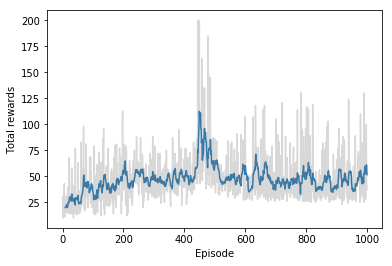

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

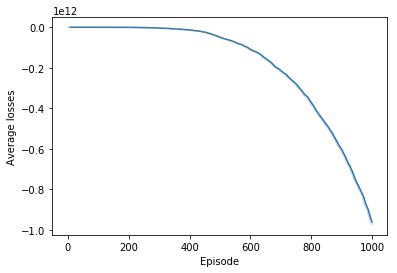

In [25]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        
        # Steps/batches
        for _ in range(111111111111111111111):
            env.render()
            
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            if done:
                break
                
    # Closing the env
    env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.